In [1]:
#import packages
import vedo
import numpy as np
import pandas as pd
import json
import glob
import os
import networkx as nx
import ast
from nxviz import utils
from operator import itemgetter
from skimage import img_as_uint, exposure
from skimage.io import imread
import warnings
warnings.filterwarnings('ignore')

/Users/tsantinghsu/miniforge3/envs/geo_env/lib/python3.9/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
#import CCFv3 template reference lists of all experimental groups

WT_ctrl_list = pd.read_csv("WT_ctrl_list.csv", index_col = 0)
Tbr1_ctrl_list= pd.read_csv("Tbr1_ctrl_list.csv", index_col = 0)
WT_TBS_list= pd.read_csv("WT_TBS_list.csv", index_col = 0)
Tbr1_TBS_list= pd.read_csv("Tbr1_TBS_list.csv", index_col = 0)

In [3]:
#subset reference list for 3D mapping of oChIEF signals

WT_ctrl_oChIEFlist = WT_ctrl_list.drop("022121 Tbr1 wt 3 nost", axis = 1)
Tbr1_ctrl_oChIEFlist = Tbr1_ctrl_list.drop("041821 Tbr1 21 nost", axis = 1)
WT_TBS_oChIEFlist = WT_TBS_list
Tbr1_TBS_oChIEFlist = Tbr1_TBS_list

#combine oChIEF reference list
WT_oChIEF_list = pd.concat([WT_ctrl_oChIEFlist, WT_TBS_oChIEFlist], axis = 1)
Tbr1_oChIEF_list = pd.concat([Tbr1_ctrl_oChIEFlist, Tbr1_TBS_oChIEFlist], axis = 1)

WT_oChIEF_list_m = pd.melt (WT_oChIEF_list)
WT_slice_list = np.unique (WT_oChIEF_list_m["value"].dropna().astype("int"))
Tbr1_oChIEF_list_m = pd.melt (Tbr1_oChIEF_list)
Tbr1_slice_list = np.unique (Tbr1_oChIEF_list_m["value"].dropna().astype("int"))

In [4]:
#generate region_masked oChIEF distribution dataframe
#Example: Figure 2D WT

#loading structure list for ploting

DMN_list = ["ACAd", "ACAv", "PL", "ILA", "ORBl", "ORBm", "ORBvl", 
            "VISa", "VISam", "RSPagl", "RSPd", "RSPv", 
            "SSp-tr", "SSp-ll", "MOs"]

#generate region_masked oChIEF distribution dataframe function

structure_list_dropempty = pd.read_csv("CCFv3/structuretree/structure_list_paper.csv", index_col = None)

ROI_corrected_structure_L =  ["LA", "BLA", "amc", "VISam", "CP", "AI", "VISC", "ORBvl", "TEa", "AIp", "ORBl", "ACAd", "BLAa",
                              "AUD", "ACAv", "PL", "ILA", "RSPv", "RSPd", "RSPagl", "VISa", "MOs", "SSp-tr", "SSp-ll", "act", "ORBm", "PP",
                              "CM", "RH", "PCN", "PF", "CL", "PIL", "AUDd", "AUDv", "PVpo",
                              "RSP", "ORB", "ACA", "ILM", "AId", "VTA", "RE", "BLAp"]

ROI_corrected_structure_R = ["LA", "BLA", "ORBvl", "PBG", "SAG", "FRP", "APr", "VISam", "scp", "CP", "AI", "VISC", "TEa", "AIp", "ORBl", "ACAd", "BLAa",
                             "AUD", "ORBm", "ACAv", "PL", "ILA", "RSPv", "RSPd", "RSPagl", "VISa", "MOs", "SSp-tr", "SSp-ll", "PPN", "PP", "RCH", "ORBm",
                             "CM", "RH", "PCN", "PF", "CL", "PIL", "AUDd", "AUDv", "DG", "VTA",
                             "RSP", "ORB", "ACA", "ILM", "AId", "PVpo", "RE", "SCop", "SCdg"]


def create_structure_average_mask_L (genotype, slice_list, reference_list, structure_list):
    pd_all = pd.DataFrame()
    for structure in structure_list:
        mask_n_list = [b for b in json.loads(structure_list_dropempty["section_number"][structure_list_dropempty[structure_list_dropempty.LABEL==structure].index[0]]) if b in slice_list]
        img_mask_stack=[]
        for c in slice_list:
            if c not in mask_n_list:
                mask_b = np.zeros ([800, 1140])
                img_mask_stack.append(mask_b)
            else:             
                if structure in ROI_corrected_structure_L:
                    file_path_list = []
                    for name_L in glob.glob("quantification/"+genotype+"/*/mask_L/"+structure+"/*"):
                        path_L,folder_name_L = os.path.split(name_L)
                        if folder_name_L in reference_list.columns:
                            for root_L, dirs_L, files_L in os.walk (name_L):
                                for file_L in files_L:
                                    if file_L.endswith ("mask"+str(c)+".png"):
                                        file_path_L = os.path.join(root_L, "mask"+str(c)+".png")
                                        file_path_list.append(file_path_L)
                    average_img_L = np.zeros((800, 570))
                    n_L = len(file_path_list)
                    for im_L in file_path_list:
                        imarr_L = np.array(imread (im_L))
                        average_img_L = average_img_L + imarr_L/n_L
                    average_img_r_L = exposure.rescale_intensity(average_img_L, out_range='float')
                    average_img = img_as_uint(np.concatenate((average_img_r_L, np.zeros((800, 570))), axis = 1))/65535
                    img =imread("./"+genotype+"_small_oChIEF_b_average_folder/oChIEF_sb"+"%04d"%c+".png")
                    img_mask = average_img*img
                    img_mask_stack.append (img_mask)
                    
                else: 
                    #CCFv3 coronal masks are downloaded through AllenSDK https://allensdk.readthedocs.io/en/latest/_static/examples/nb/reference_space.html
                    file_path = "CCFv3/mask/mask"+str(structure_list_dropempty[structure_list_dropempty["LABEL"]==structure]["IDX"].values[0])+"/" 
                    for root_L, dirs_L, files_L in os.walk (file_path):
                        for file_L in files_L:
                            if file_L.endswith("mask"+str(c)+".csv"):
                                file_path_L = os.path.join(root_L, "mask"+str(c)+".csv")
                                imarr_L = pd.read_csv(file_path_L, header = 0, index_col = 0).values[:, :570]
                                average_img_r_L = exposure.rescale_intensity(imarr_L, out_range='float')
                                average_img = img_as_uint(np.concatenate((average_img_r_L, np.zeros((800, 570))), axis = 1))/65535
                                img =imread("./"+genotype+"_small_oChIEF_b_average_folder/oChIEF_sb"+"%04d"%c+".png") #data will be avaiable after publication
                                img_mask = average_img*img
                                img_mask_stack.append (img_mask)
                            
        np_img = np.array(img_mask_stack)
        z, y, x = np.where(np_img>0)
        pd_loc = pd.DataFrame({"z":z, "y":y, "x":x})

        img_value_list =[]
        for indexa, varaa in pd_loc.iterrows():
            img_value = np_img[varaa["z"]][varaa["y"]][varaa["x"]]
            img_value_list.append(img_value)

        if len(img_value_list)>0:
            pd_loc["alpha"] = (img_value_list/max(img_value_list))*100
        else:
            pd_loc["alpha"] = 0
        pd_loc["value"] = img_value_list
        pd_loc["x"] = pd_loc["x"].values*10
        pd_loc["y"] = pd_loc["y"].values*10
        pd_loc["z"] = slice_list[pd_loc["z"].values]*10
        pd_loc["R"] = structure_list_dropempty[structure_list_dropempty["LABEL"]==structure]["-R-"].values[0]
        pd_loc["G"] = structure_list_dropempty[structure_list_dropempty["LABEL"]==structure]["-G-"].values[0]
        pd_loc["B"] = structure_list_dropempty[structure_list_dropempty["LABEL"]==structure]["-B-"].values[0]
        pd_loc["structure"]=structure
        pd_loc["hemisphere"]="contra"
        pd_all = pd.concat([pd_all, pd_loc], axis = 0)
    return pd_all

def create_structure_average_mask_R (genotype, slice_list, reference_list, structure_list):
    pd_all = pd.DataFrame()
    for structure in structure_list:
        mask_n_list = [b for b in json.loads(structure_list_dropempty["section_number"][structure_list_dropempty[structure_list_dropempty.LABEL==structure].index[0]]) if b in slice_list]
        img_mask_stack=[]
        for c in slice_list:
            if c not in mask_n_list:
                mask_b = np.zeros ([800, 1140])
                img_mask_stack.append(mask_b)
            else:             
                if structure in ROI_corrected_structure_R:
                    file_path_list = []
                    for name_R in glob.glob("quantification/"+genotype+"/*/mask_R/"+structure+"/*"):
                        path_R,folder_name_R = os.path.split(name_R)
                        if folder_name_R in reference_list.columns:
                            for root_R, dirs_R, files_R in os.walk (name_R):
                                for file_R in files_R:
                                    if file_R.endswith ("mask"+str(c)+".png"):
                                        file_path_R = os.path.join(root_R, "mask"+str(c)+".png")
                                        file_path_list.append(file_path_R)
                    average_img_R = np.zeros((800, 570))
                    n_R = len(file_path_list)
                    for im_R in file_path_list:
                        imarr_R = np.array(imread (im_R))
                        average_img_R = average_img_R + imarr_R/n_R
                    average_img_r_R = exposure.rescale_intensity(average_img_R, out_range='float')
                    average_img = img_as_uint(np.concatenate((np.zeros((800, 570)), average_img_r_R), axis = 1))/65535
                    img =imread("./"+genotype+"_small_oChIEF_b_average_folder/oChIEF_sb"+"%04d"%c+".png")
                    img_mask = average_img*img
                    img_mask_stack.append (img_mask)
                    
                else:
                    #CCFv3 coronal masks are downloaded through AllenSDK https://allensdk.readthedocs.io/en/latest/_static/examples/nb/reference_space.html
                    file_path = "CCFv3/mask/mask"+str(structure_list_dropempty[structure_list_dropempty["LABEL"]==structure]["IDX"].values[0])+"/"
                    for root_R, dirs_R, files_R in os.walk (file_path):
                        for file_R in files_R:
                            if file_R.endswith("mask"+str(c)+".csv"):
                                file_path_R = os.path.join(root_R, "mask"+str(c)+".csv")
                                imarr_R = pd.read_csv(file_path_R, header = 0, index_col = 0).values[:, 570:]
                                average_img_r_R = exposure.rescale_intensity(imarr_R, out_range='float')
                                average_img = img_as_uint(np.concatenate((np.zeros((800, 570)), average_img_r_R), axis = 1))/65535                            
                                img =imread("./"+genotype+"_small_oChIEF_b_average_folder/oChIEF_sb"+"%04d"%c+".png") #data will be avaiable after publication                             
                                img_mask = average_img*img
                                img_mask_stack.append (img_mask)
                            
        np_img = np.array(img_mask_stack)
        z, y, x = np.where(np_img>0)
        pd_loc = pd.DataFrame({"z":z, "y":y, "x":x})

        img_value_list =[]
        for indexa, varaa in pd_loc.iterrows():
            img_value = np_img[varaa["z"]][varaa["y"]][varaa["x"]]
            img_value_list.append(img_value)

        if len(img_value_list)>0:
            pd_loc["alpha"] = (img_value_list/max(img_value_list))*100
        else:
            pd_loc["alpha"] = 0
        pd_loc["value"] = img_value_list
        pd_loc["x"] = pd_loc["x"].values*10
        pd_loc["y"] = pd_loc["y"].values*10
        pd_loc["z"] = slice_list[pd_loc["z"].values]*10
        pd_loc["R"] = structure_list_dropempty[structure_list_dropempty["LABEL"]==structure]["-R-"].values[0]
        pd_loc["G"] = structure_list_dropempty[structure_list_dropempty["LABEL"]==structure]["-G-"].values[0]
        pd_loc["B"] = structure_list_dropempty[structure_list_dropempty["LABEL"]==structure]["-B-"].values[0]
        pd_loc["structure"]=structure
        pd_loc["hemisphere"]="ipsi"
        pd_all = pd.concat([pd_all, pd_loc], axis = 0)
    return pd_all

WT_contra= create_structure_average_mask_L ("WT", WT_slice_list, WT_oChIEF_list, DMN_list)
WT_ipsi= create_structure_average_mask_R ("WT", WT_slice_list, WT_oChIEF_list, DMN_list)
WT_oChIEF_U = pd.concat([WT_contra, WT_ipsi], axis = 0)
Tbr1_contra= create_structure_average_mask_L ("Tbr1", Tbr1_slice_list, Tbr1_oChIEF_list, DMN_list)
Tbr1_ipsi= create_structure_average_mask_R ("Tbr1", Tbr1_slice_list, Tbr1_oChIEF_list, DMN_list)
Tbr1_oChIEF_U = pd.concat([Tbr1_contra, Tbr1_ipsi], axis = 0)

In [5]:
#assign new color to brain regions
def assign_color (df):
    kelly_palette = ["#F3C300", "#875692", "#F38400", "#A1CAF1", "#BE0032", "#C2B280",
                         "#008856", "#E68FAC", "#0067A5", "#F99379", "#604E97", 
                         "#F6A600", "#B3446C", "#DCD300", "#882D17", "#8DB600", "#654522", 
                         "#E25822", "#2B3D26", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
                         "#9467bd", "#8c564b", "#e377c2", "#bcbd22", "#17becf"]

    unique_color_structure = list(np.unique(df["structure"]))


    unique_color_dict = {unique_color_structure[i]:kelly_palette[i] for i, a in enumerate (unique_color_structure)}
    color_code = list(itemgetter(*list(df["structure"]))(unique_color_dict))
    df["color"]=color_code
assign_color (WT_oChIEF_U)
assign_color (Tbr1_oChIEF_U)

def hex_to_rgb_df (df):
    def hex_to_rgb(hex):
        return tuple(int(hex[i:i+2], 16) for i in (1, 3, 5))

    RGB_tuple_list = []
    for a in df["color"]:
        RGB_tuple_list.append (hex_to_rgb (a))

    R_c_list = []
    G_c_list = []
    B_c_list = []
    for b in RGB_tuple_list:
        R_c, G_c, B_c = b
        R_c_list.append(R_c)
        G_c_list.append(G_c)
        B_c_list.append(B_c)

    df["R_c"] = R_c_list
    df["G_c"] = G_c_list
    df["B_c"] = B_c_list
    
    return df
    
WT_oChIEF_U_re = hex_to_rgb_df(WT_oChIEF_U)
Tbr1_oChIEF_U_re = hex_to_rgb_df(Tbr1_oChIEF_U)

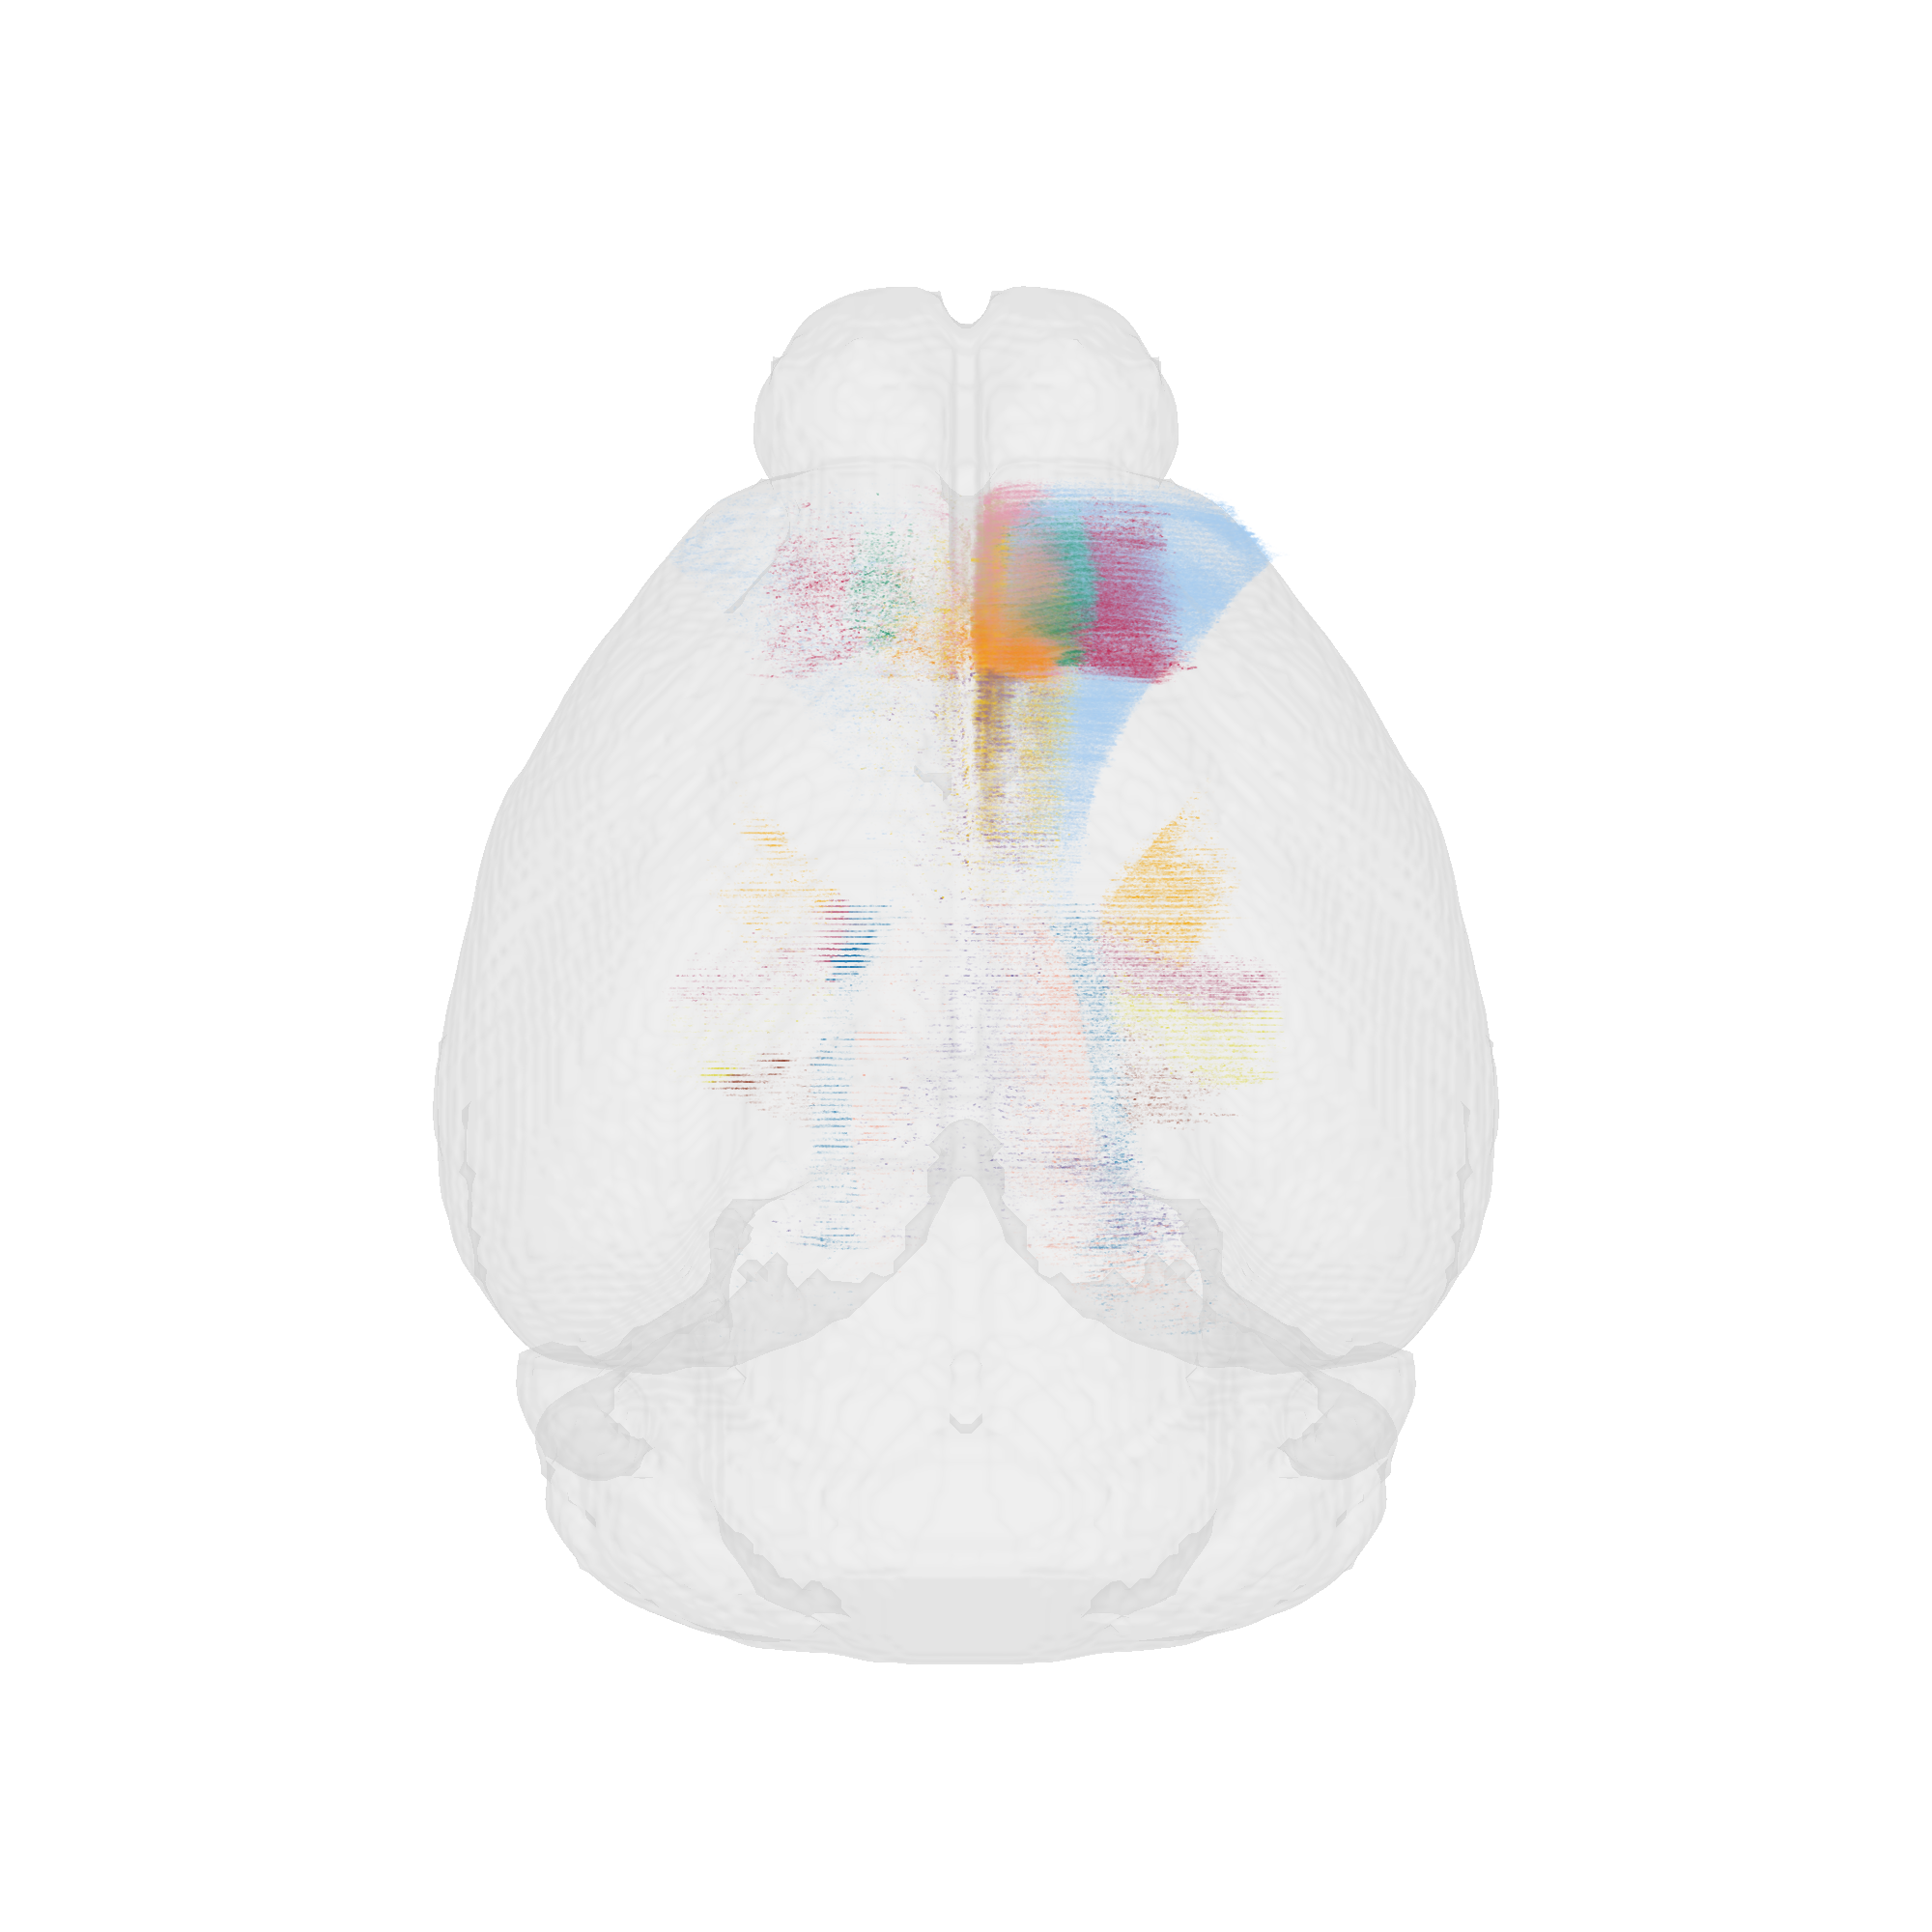

In [6]:
#3D mapping of oChIEF distributions
#Example: Figure S8A WT
root = vedo.load("root_small.vtk")
root.cmap("gray_r").alpha(0.4).lighting("ambient")
pts = vedo.Points(WT_oChIEF_U_re[["z","y", "x"]].values, c = WT_oChIEF_U_re[["R_c","G_c", "B_c", "alpha"]].values).point_size(1.5)

#show 3D mapping
vedo.settings.default_backend ='2d'
vedo.show(root, pts, azimuth=0, elevation=-90, roll=270, resetcam = True, zoom = 1, size=(2000, 2000))

In [7]:
#create oChIEF difference pixels

WT_ipsi["xyz"]=[(varaa["z"], varaa["y"], varaa["x"]) for indexa, varaa in WT_ipsi.iterrows()]
Tbr1_ipsi["xyz"]=[(varaa["z"], varaa["y"], varaa["x"]) for indexa, varaa in Tbr1_ipsi.iterrows()]
WT_ipsi.set_index(["xyz"], inplace = True)
Tbr1_ipsi.set_index(["xyz"], inplace = True)
WT_ipsi_down_group = WT_ipsi.drop(["structure", "hemisphere"], axis =1).groupby(WT_ipsi.index).mean()
Tbr1_ipsi_down_group = Tbr1_ipsi.drop(["structure", "hemisphere"], axis =1).groupby(Tbr1_ipsi.index).mean()

WT_contra["xyz"]=[(varaa["z"], varaa["y"], varaa["x"]) for indexa, varaa in WT_contra.iterrows()]
Tbr1_contra["xyz"]=[(varaa["z"], varaa["y"], varaa["x"]) for indexa, varaa in Tbr1_contra.iterrows()]
WT_contra.set_index(["xyz"], inplace= True)
Tbr1_contra.set_index(["xyz"], inplace = True)
WT_contra_down_group = WT_contra.drop(["structure", "hemisphere"], axis =1).groupby(WT_contra.index).mean()
Tbr1_contra_down_group = Tbr1_contra.drop(["structure", "hemisphere"], axis =1).groupby(Tbr1_contra.index).mean()

def oChIEF_pixel_diff (df1, df2):

    common_xyz = list(set(df1.index.tolist()).intersection(set(df2.index.tolist())))
    diff = df2.loc[common_xyz, "value"]-df1.loc[common_xyz, "value"]
    diff_pd = pd.DataFrame({"xyz":common_xyz, "diff":diff.tolist()})
    return diff_pd

diff_oChIEF_ipsi = oChIEF_pixel_diff (WT_ipsi_down_group, Tbr1_ipsi_down_group)
diff_oChIEF_contra = oChIEF_pixel_diff (WT_contra_down_group, Tbr1_contra_down_group)
diff_oChIEF = pd.concat([diff_oChIEF_ipsi, diff_oChIEF_contra])

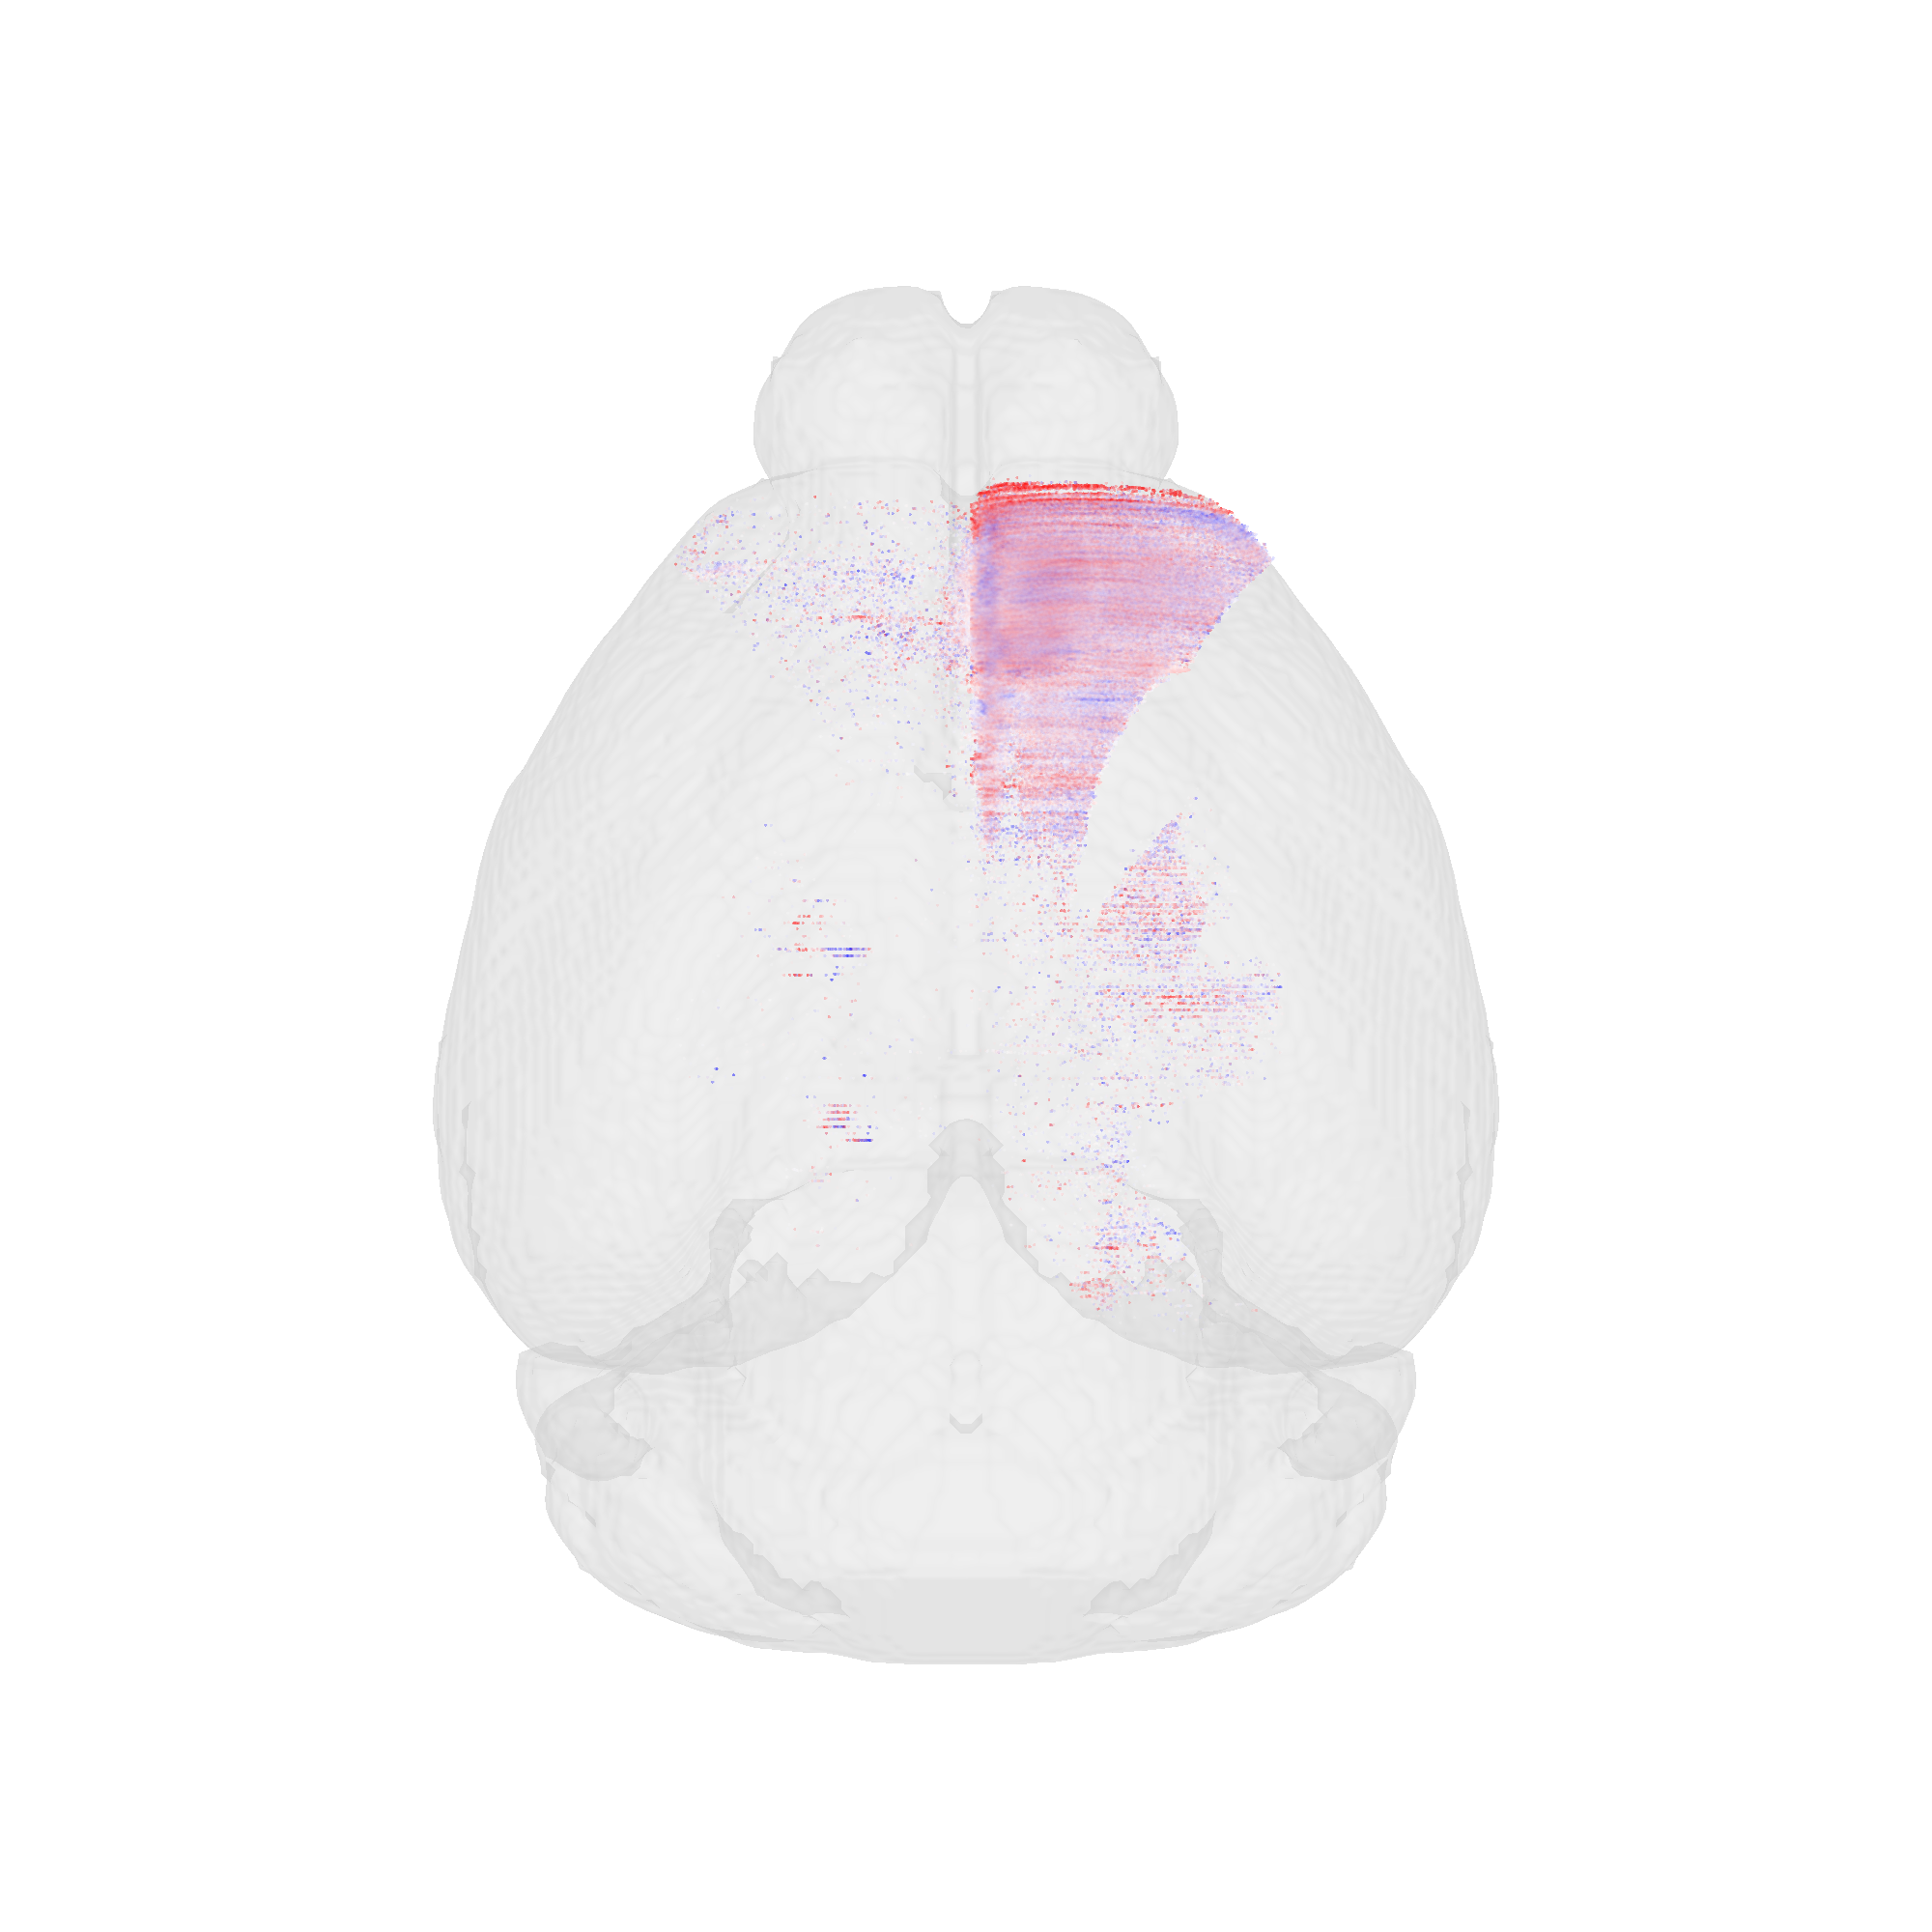

In [8]:
#3D mapping of oChIEF distribution difference
#Example:Figure 7A left panel

xyz_list = diff_oChIEF["xyz"].tolist()
diff_list = diff_oChIEF["diff"].tolist()
vmin, vmax = np.min(diff_list), np.max(diff_list)
scale = abs(vmax-vmin)
scale_diff = diff_list/scale

color = [vedo.color_map(v, "bwr", -0.1, 0.1) for v in scale_diff]
s = vedo.Points(np.array(xyz_list), c = color, alpha=0.5).point_size(3)
root = vedo.load("root_small.vtk")
root.cmap("gray_r").alpha(0.4).lighting("ambient")

#show 3D mapping
vedo.settings.default_backend ='2d'
vedo.show(root, s, azimuth=0, elevation=-90, roll=270, resetcam = True, zoom = 1, size = (2000,2000))

In [9]:
#loading C-FOS positive cell locations in DMN regions for 3D mapping of C-FOS distributions

WT_ctrl_cfos_loc_DMN = pd.read_csv("./WT_ctrl_cfos_loc_DMN.csv", index_col=0)
Tbr1_ctrl_cfos_loc_DMN = pd.read_csv("./Tbr1_ctrl_cfos_loc_DMN.csv", index_col=0)
WT_TBS_cfos_loc_DMN = pd.read_csv("./WT_TBS_cfos_loc_DMN.csv", index_col=0)
Tbr1_TBS_cfos_loc_DMN = pd.read_csv("./Tbr1_TBS_cfos_loc_DMN.csv", index_col=0)

In [10]:
#binning cfos_spot by quantization scale micrometer

def scale_down (df, scale_level, reference_list):
    """scale down cfos_spot by quantization defined micrometer and add structure name"""

    df[["x(micrometer)", "y(micrometer)", "z(micrometer)"]]//=scale_level
    df[["x(micrometer)", "y(micrometer)", "z(micrometer)"]]*=scale_level
    df = df.groupby (df.columns.tolist(), as_index = False).size()
    df["Density (cells/cubic millimeter)"]= (df["size"]/((scale_level*0.001)**3))/len(reference_list.columns)

    return df

WT_ctrl_cfos_loc_DMN_down = scale_down (WT_ctrl_cfos_loc_DMN, 100, WT_ctrl_list)
Tbr1_ctrl_cfos_loc_DMN_down = scale_down (Tbr1_ctrl_cfos_loc_DMN, 100, Tbr1_ctrl_list)
WT_TBS_cfos_loc_DMN_down = scale_down (WT_TBS_cfos_loc_DMN, 100, WT_TBS_list)
Tbr1_TBS_cfos_loc_DMN_down = scale_down (Tbr1_TBS_cfos_loc_DMN, 100, Tbr1_TBS_list)

In [11]:
#construct structure color map
structure_list_parent_v1 = pd.read_csv ("CCFv3/structuretree/structure_list_paper.csv", index_col = 0)

def structure_color_list (df):
    """construct structure color map"""
    cfos_structure_list = list(df["structure"])
    label_list = list(structure_list_parent_v1["LABEL"])
    label_dict = {si : i for i,si in enumerate(label_list)}
    index_list = list(itemgetter(*cfos_structure_list)(label_dict))
    color_list = structure_list_parent_v1.iloc[index_list][['-R-','-G-','-B-']]
    color_tuple = [tuple(x) for x in color_list.to_numpy()]
    color_code = ['#%02x%02x%02x' % (x) for x in color_tuple]
       
    return color_code
WT_ctrl_cfos_loc_DMN_down["color"] = structure_color_list(WT_ctrl_cfos_loc_DMN_down)
Tbr1_ctrl_cfos_loc_DMN_down["color"] = structure_color_list(Tbr1_ctrl_cfos_loc_DMN_down)
WT_TBS_cfos_loc_DMN_down["color"] = structure_color_list(WT_TBS_cfos_loc_DMN_down)
Tbr1_TBS_cfos_loc_DMN_down["color"] = structure_color_list(Tbr1_TBS_cfos_loc_DMN_down)

#add area
parent_structure = pd.read_csv ("CCFv3/structuretree/structure_list_paper_cfos.csv", index_col = 0)

def area_structure (df):
    structure_list = list(df["structure"])
    label_list = list(parent_structure["LABEL"])
    label_dict = {si : i for i,si in enumerate(label_list)}
    index_list = list(itemgetter(*structure_list)(label_dict))
    area = parent_structure.iloc[index_list]["area"].tolist()
    return area

WT_ctrl_cfos_loc_DMN_down["area"] = area_structure(WT_ctrl_cfos_loc_DMN_down)
Tbr1_ctrl_cfos_loc_DMN_down["area"] = area_structure(Tbr1_ctrl_cfos_loc_DMN_down)
WT_TBS_cfos_loc_DMN_down["area"] = area_structure(WT_TBS_cfos_loc_DMN_down)
Tbr1_TBS_cfos_loc_DMN_down["area"] = area_structure(Tbr1_TBS_cfos_loc_DMN_down)

#add area color
area_list = ["Prefrontal", "Somatomotor", "Medial", "Lateral", "Auditory", "Visual", "Olfactory areas", "Hippocampal formation", "Cortical subplate", 
                     "Cerebral nuclei", "Thalamus", "Hypothalamus", "Midbrain", "Hindbrain"]


area_color = ["#C9181B", "#D28230", "#453B93", "#F9FF62", "#5C2E84", "#92ACF2", "#9AD2BD", "#7ED04B", "#8ADA87", "#98D6F9", "#FF7080", "#ff4c3e",
                      "#fe90fe", "#ffc395"]
area_color_dict = dict(zip(area_list, area_color))

WT_ctrl_cfos_loc_DMN_down["area_color"] = [area_color_dict[a] for a in WT_ctrl_cfos_loc_DMN_down["area"].tolist()]
Tbr1_ctrl_cfos_loc_DMN_down["area_color"] = [area_color_dict[a] for a in Tbr1_ctrl_cfos_loc_DMN_down["area"].tolist()]
WT_TBS_cfos_loc_DMN_down["area_color"] = [area_color_dict[a] for a in WT_TBS_cfos_loc_DMN_down["area"].tolist()]
Tbr1_TBS_cfos_loc_DMN_down["area_color"] = [area_color_dict[a] for a in Tbr1_TBS_cfos_loc_DMN_down["area"].tolist()]

In [12]:
#assign unique color for DMN regions
def assign_color (df):
    kelly_palette = ["#F3C300", "#875692", "#F38400", "#A1CAF1", "#BE0032", "#C2B280",
                         "#008856", "#E68FAC", "#0067A5", "#F99379", "#604E97", 
                         "#F6A600", "#B3446C", "#DCD300", "#882D17", "#8DB600", "#654522", 
                         "#E25822", "#2B3D26", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
                         "#9467bd", "#8c564b", "#e377c2", "#bcbd22", "#17becf"]


    unique_color_structure = ['ACAd', 'ACAv', 'ILA', 'MOs', 'ORBl',
                              'ORBm', 'ORBvl', 'PL', 'RSPagl', 'RSPd',
                              'RSPv', 'SSp-ll', 'SSp-tr', 'VISa', 'VISam']
    
    print (unique_color_structure)

    unique_color_dict = {unique_color_structure[i]:kelly_palette[i] for i, a in enumerate (unique_color_structure)}
    color_code = list(itemgetter(*list(df["structure"]))(unique_color_dict))
    df["kelly_color"]=color_code
    
assign_color (WT_ctrl_cfos_loc_DMN_down)
assign_color (Tbr1_ctrl_cfos_loc_DMN_down)
assign_color (WT_TBS_cfos_loc_DMN_down)
assign_color (Tbr1_TBS_cfos_loc_DMN_down)

['ACAd', 'ACAv', 'ILA', 'MOs', 'ORBl', 'ORBm', 'ORBvl', 'PL', 'RSPagl', 'RSPd', 'RSPv', 'SSp-ll', 'SSp-tr', 'VISa', 'VISam']
['ACAd', 'ACAv', 'ILA', 'MOs', 'ORBl', 'ORBm', 'ORBvl', 'PL', 'RSPagl', 'RSPd', 'RSPv', 'SSp-ll', 'SSp-tr', 'VISa', 'VISam']
['ACAd', 'ACAv', 'ILA', 'MOs', 'ORBl', 'ORBm', 'ORBvl', 'PL', 'RSPagl', 'RSPd', 'RSPv', 'SSp-ll', 'SSp-tr', 'VISa', 'VISam']
['ACAd', 'ACAv', 'ILA', 'MOs', 'ORBl', 'ORBm', 'ORBvl', 'PL', 'RSPagl', 'RSPd', 'RSPv', 'SSp-ll', 'SSp-tr', 'VISa', 'VISam']


In [13]:
#normalize C-FOS cube size for 3D mapping
def normalize_spot_size (spot, scale_level):
    """normalize spot size for static 3d scatter plot"""
    max_size = spot["Density (cells/cubic millimeter)"].max()
    min_size = spot["Density (cells/cubic millimeter)"].min()
    
    norm_size = (((spot["Density (cells/cubic millimeter)"] - min_size)/(max_size-min_size))*scale_level)
    return norm_size

WT_ctrl_cfos_loc_DMN_down["norm_size"] = normalize_spot_size(WT_ctrl_cfos_loc_DMN_down, 50)
Tbr1_ctrl_cfos_loc_DMN_down["norm_size"] = normalize_spot_size(Tbr1_ctrl_cfos_loc_DMN_down, 50)
WT_TBS_cfos_loc_DMN_down["norm_size"] = normalize_spot_size(WT_TBS_cfos_loc_DMN_down, 50)
Tbr1_TBS_cfos_loc_DMN_down["norm_size"] = normalize_spot_size(Tbr1_TBS_cfos_loc_DMN_down, 50)

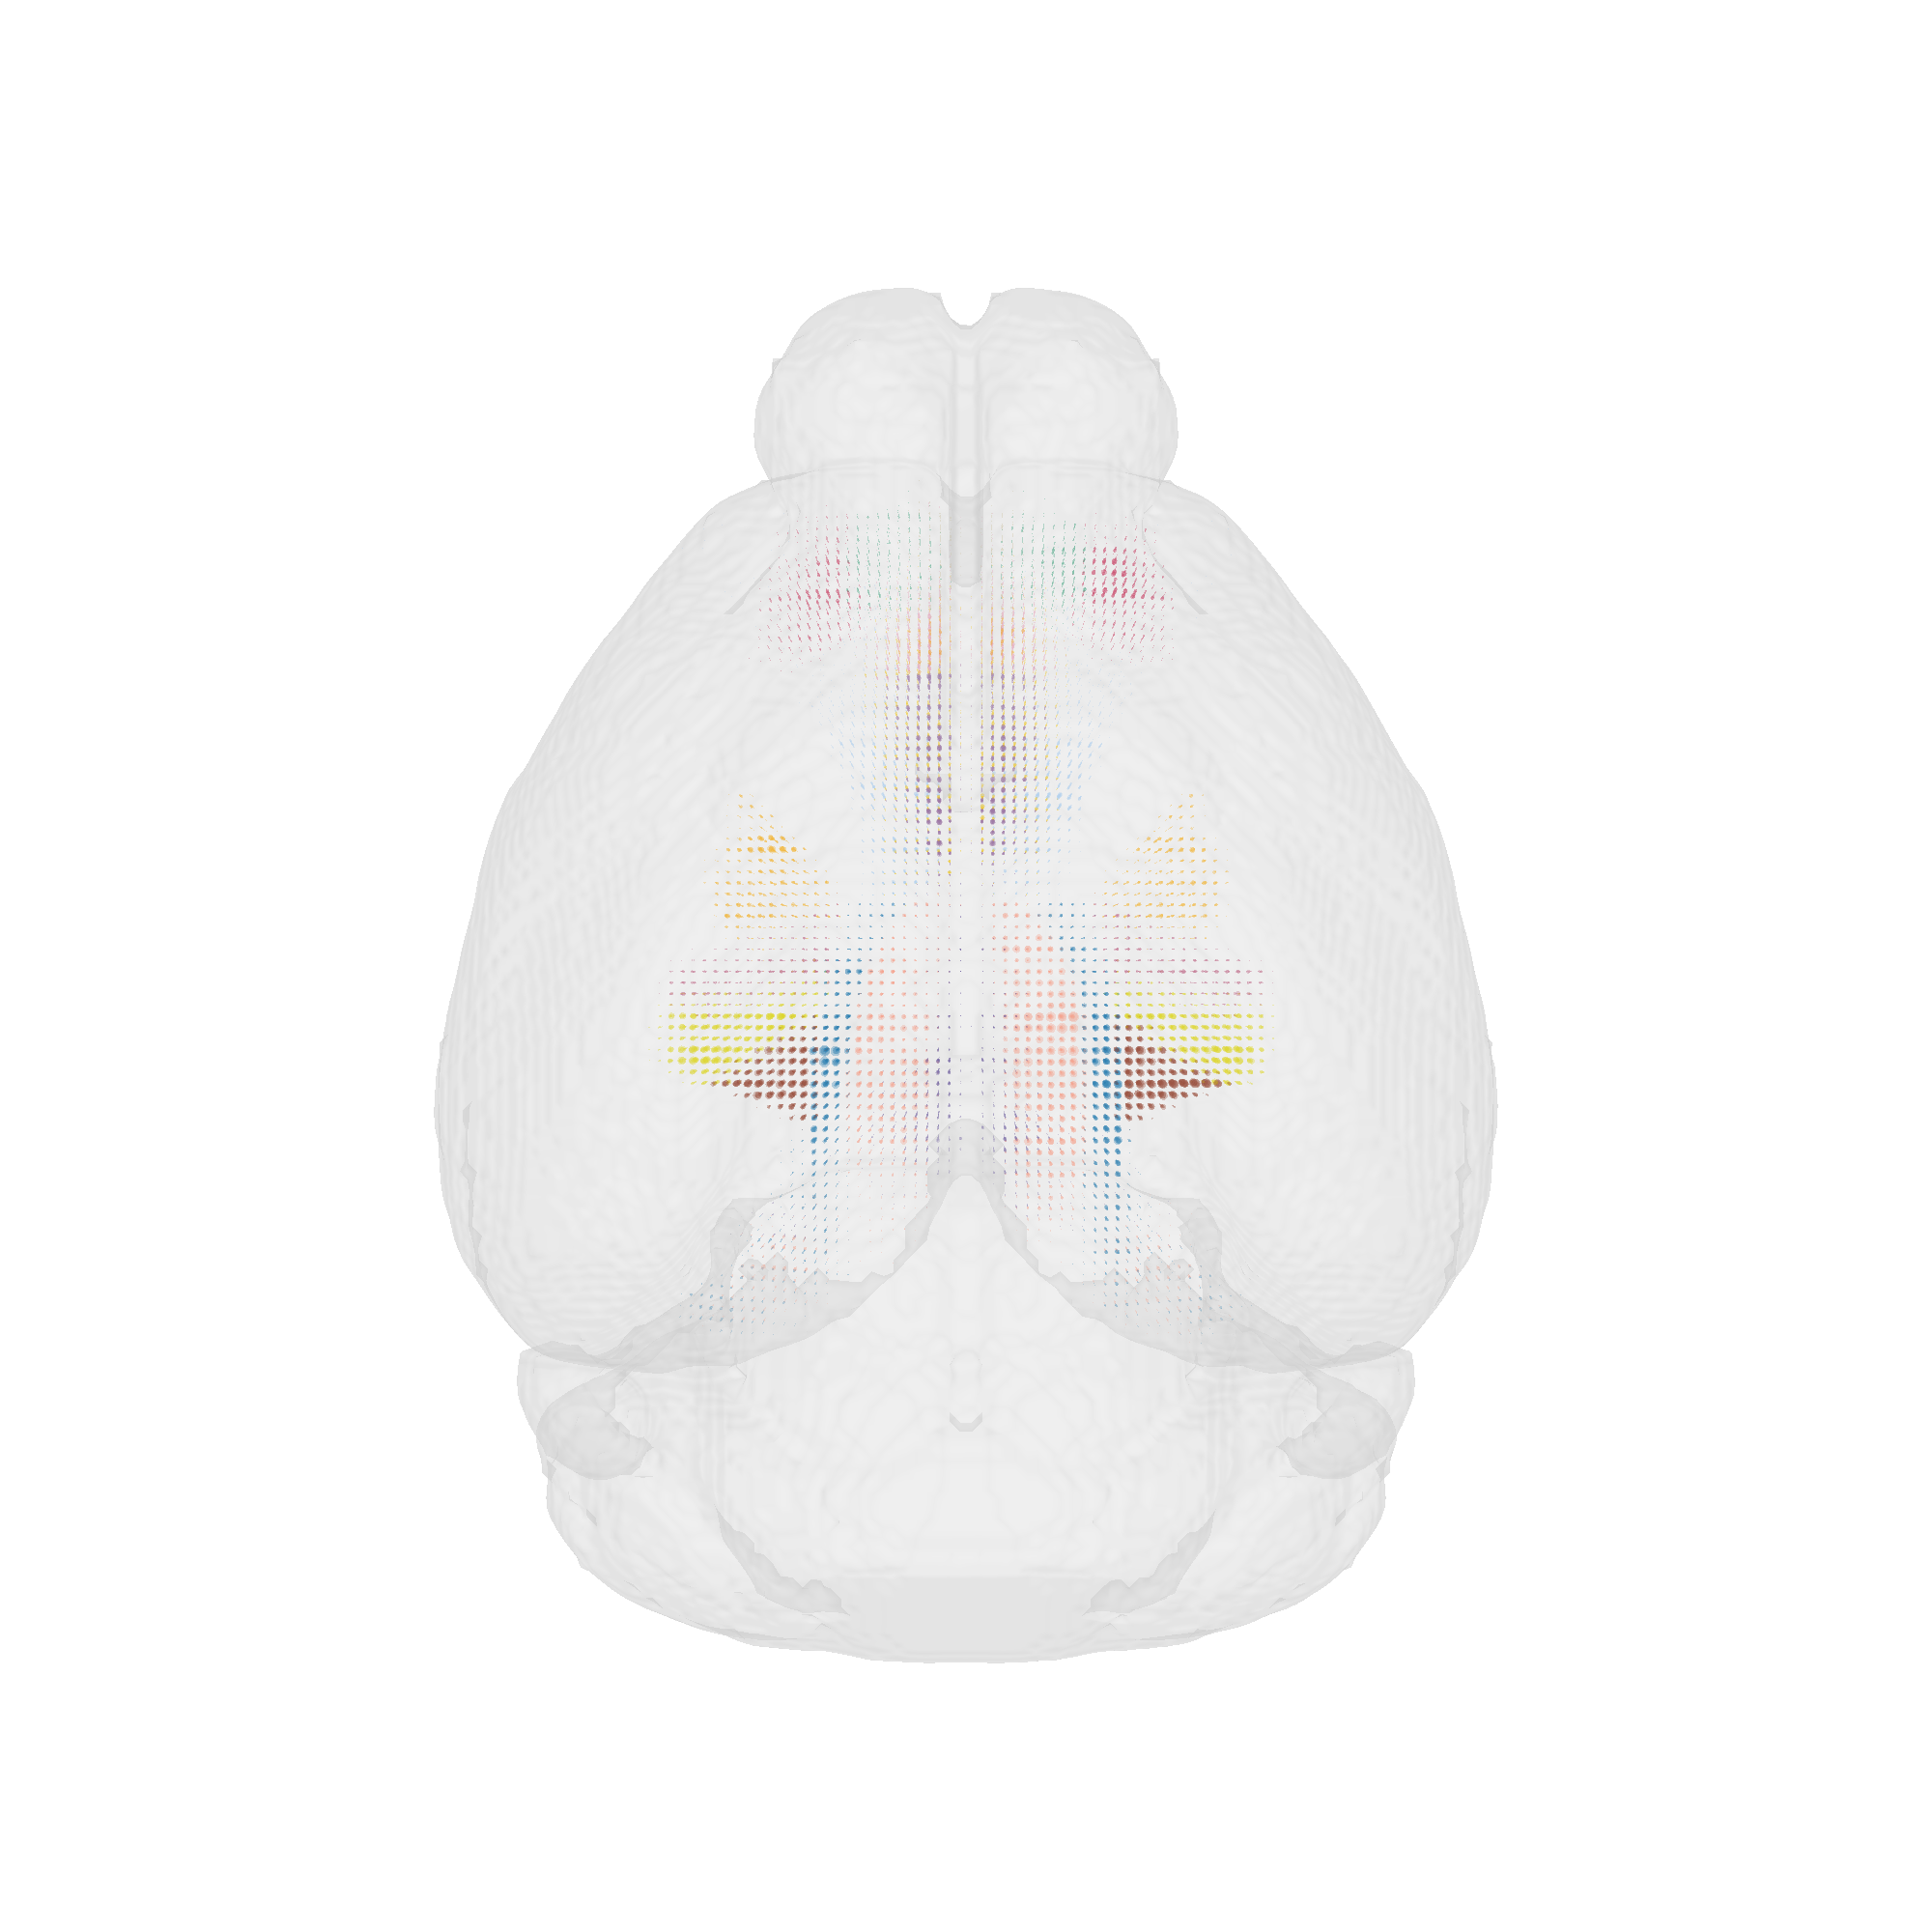

In [14]:
#3D mapping of C-FOS cubes 
#Example: Figure S8C WT ctrl


DMN_list = ["ACAd", "ACAv", "PL", "ILA", "ORBl", "ORBm", "ORBvl", 
            "VISa", "VISam", "RSPagl", "RSPd", "RSPv", 
            "SSp-tr", "SSp-ll", "MOs"]

def vedo_cfos (df, structure_list_contra, structure_list_ipsi):
    root = vedo.load("root_small.vtk")
    root.cmap("gray_r").alpha(0.4).lighting("ambient")

    model = [root]

    for a in structure_list_contra:
        contra_structure = df[(df["hemisphere"]=="Left")&(df["structure"]==a)]
        if len(contra_structure)>0:
            pts_contra = [(contra_structure["z(micrometer)"][indexa], contra_structure["y(micrometer)"][indexa], contra_structure["x(micrometer)"][indexa]) for indexa, varaa in contra_structure.iterrows()]
            color_contra = vedo.colors.build_palette(np.unique(contra_structure["kelly_color"].values)[0], np.unique(contra_structure["kelly_color"].values)[0], 2)
            contra_s = vedo.Spheres(pts_contra, r = contra_structure["norm_size"].tolist(), alpha= 0.2, res = 20).cmap(color_contra).lighting("off")

            model.append(contra_s)

    for b in structure_list_ipsi:
        ipsi_structure = df[(df["hemisphere"]=="Right")&(df["structure"]==b)]
        if len(ipsi_structure)>0:
            pts_ipsi = [(ipsi_structure["z(micrometer)"][indexb], ipsi_structure["y(micrometer)"][indexb], ipsi_structure["x(micrometer)"][indexb]) for indexb, varab in ipsi_structure.iterrows()]
            color_ipsi = vedo.colors.build_palette(np.unique(ipsi_structure["kelly_color"].values)[0], np.unique(ipsi_structure["kelly_color"].values)[0], 2)
            ipsi_s = vedo.Spheres(pts_ipsi, r = ipsi_structure["norm_size"].tolist(), alpha= 0.2, res = 20).cmap(color_ipsi).lighting("off")

            model.append(ipsi_s)

    return model

cfos_model = vedo_cfos (WT_ctrl_cfos_loc_DMN_down, DMN_list, DMN_list)

#show 3D mapping
vedo.settings.default_backend = '2d' #set to 'k3d' for interactive plotting
vedo.show(cfos_model, azimuth=0, elevation=-90, roll=270, resetcam = True, zoom = 1, size=(2000, 2000))

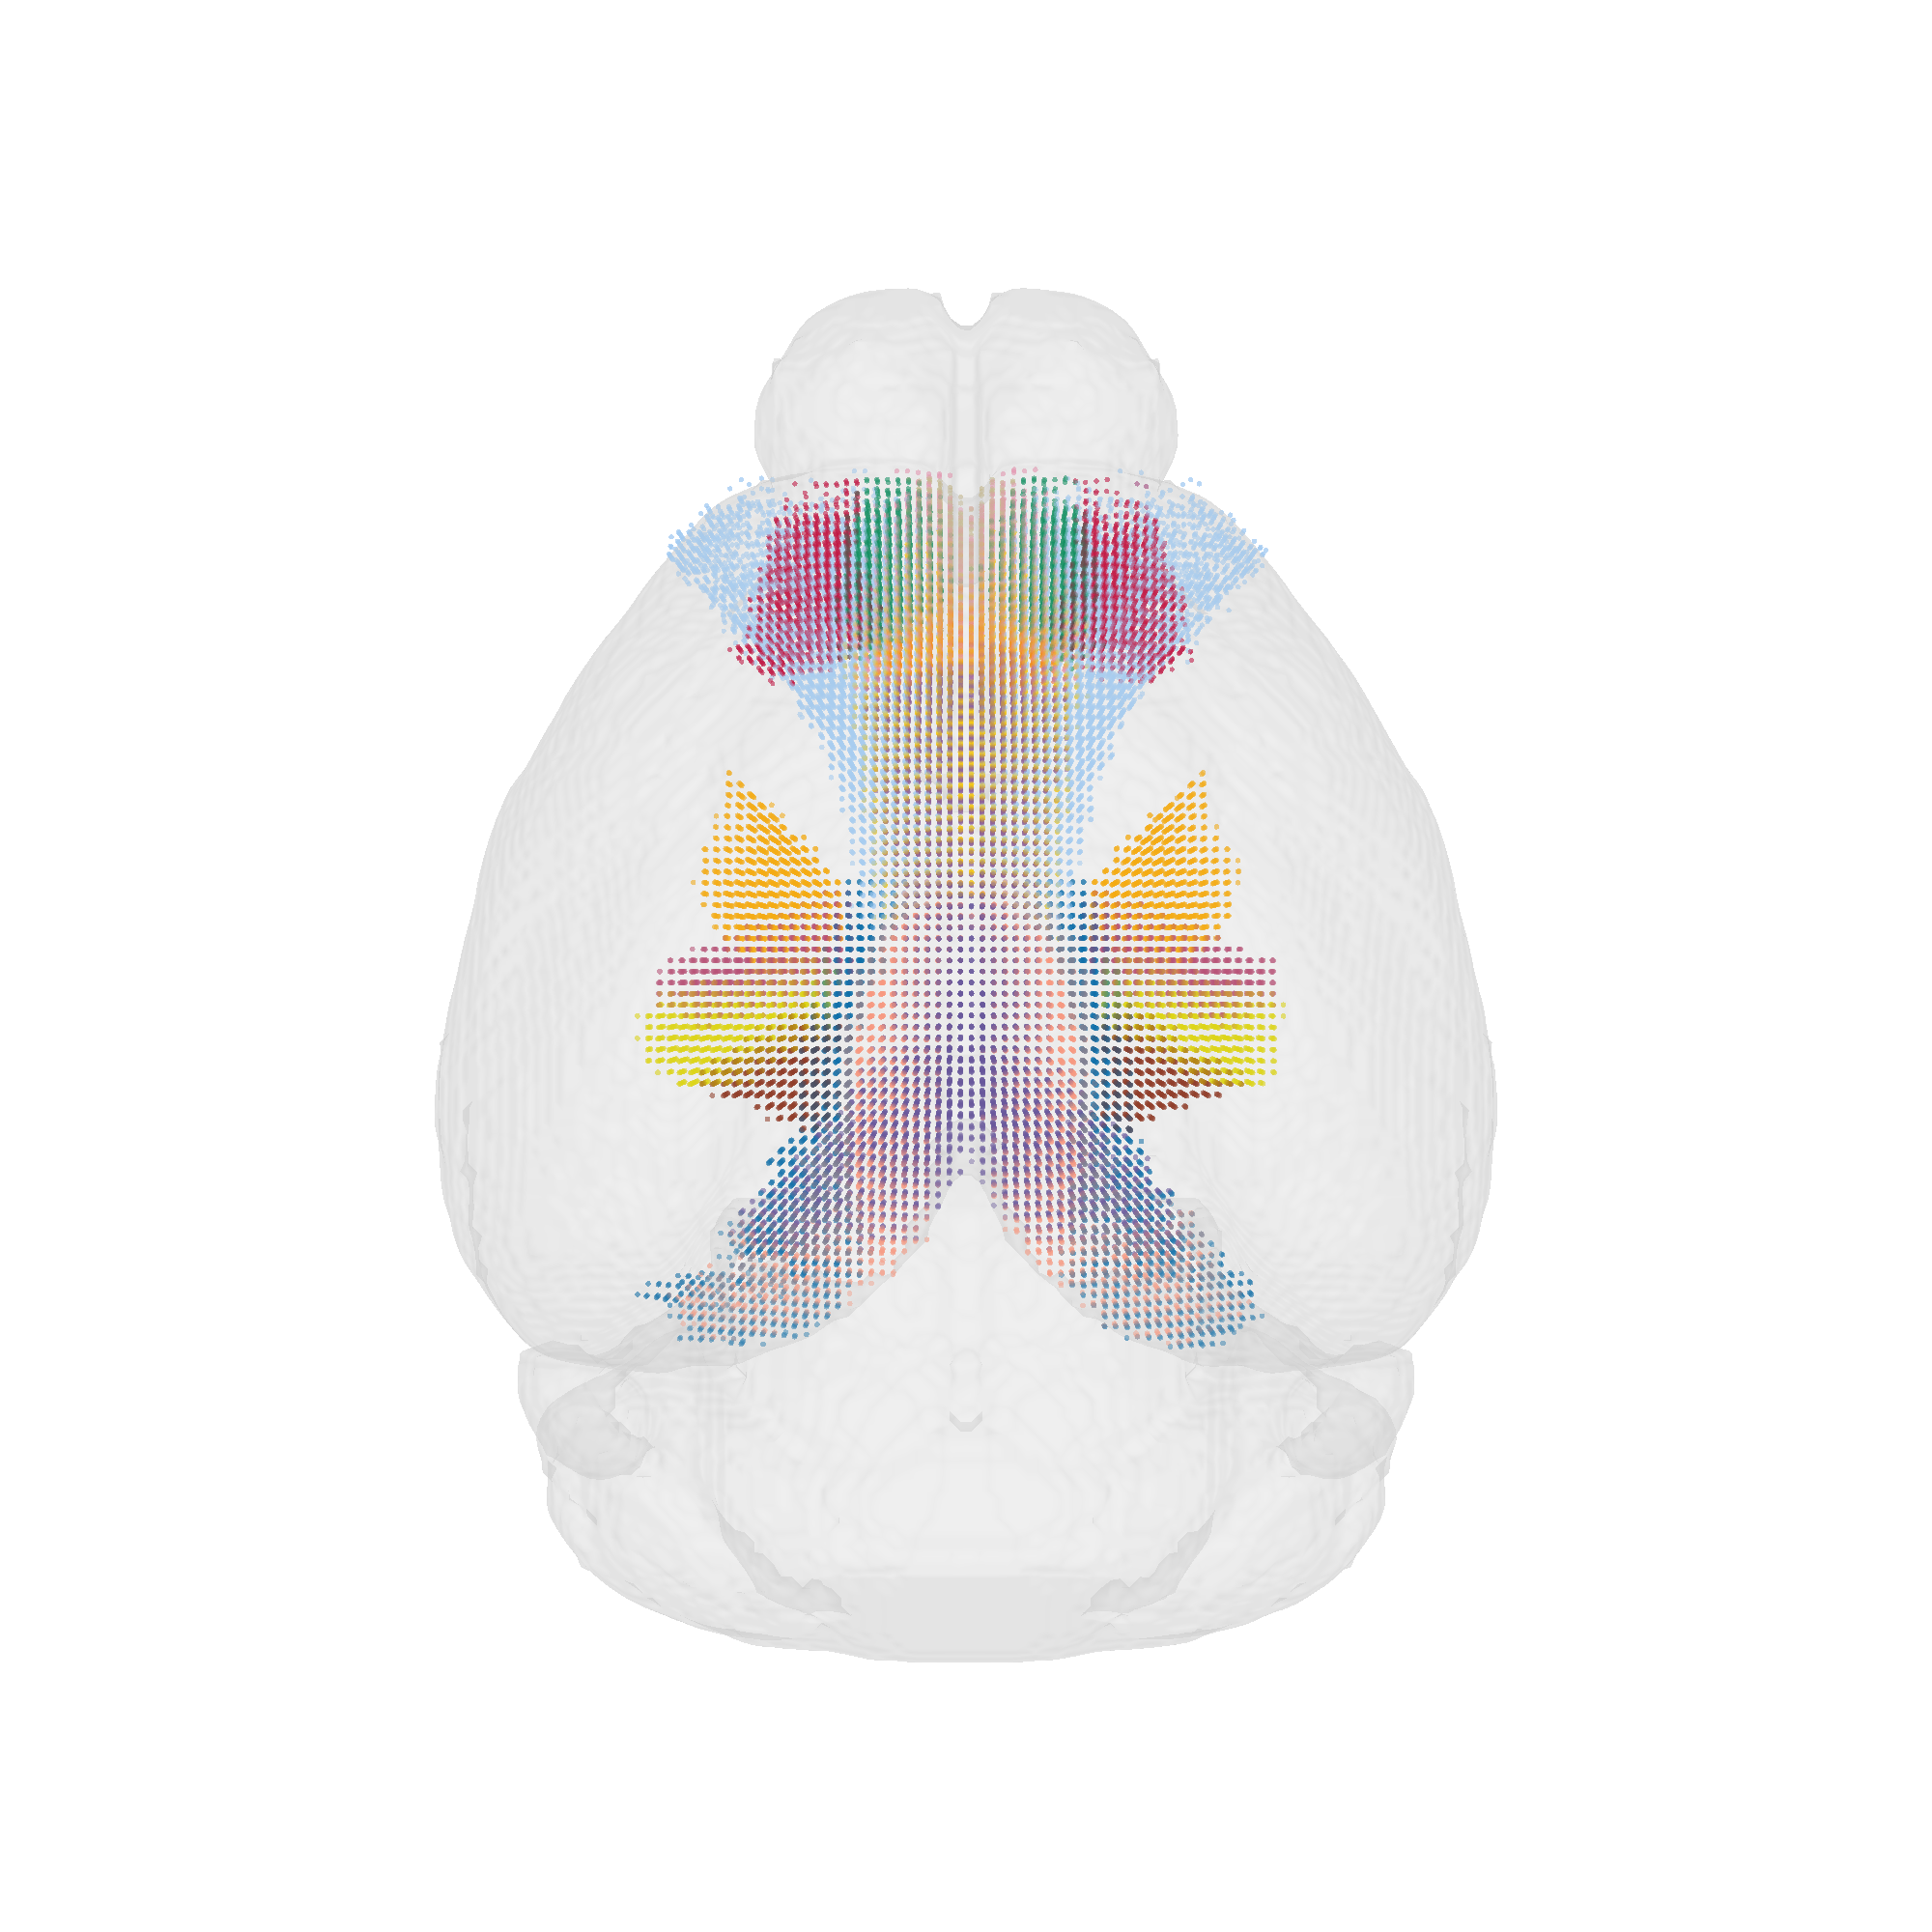

In [15]:
#plot cfos spot location and brain mask
#Example: Figure 7A right panel

def vedo_cfos_location (df, contra_list, ipsi_list):
    root = vedo.load("root_small.vtk")
    root.cmap("gray_r").alpha(0.4).lighting("ambient")

    model = [root]

    for a in contra_list:
        contra_structure = df[(df["hemisphere"]=="Left")&(df["structure"]==a)]
        df_contra = df[(df["structure"]==a)&(df["hemisphere"]=="Left")]
        if len(df_contra)>0:
            pts_contra = [(contra_structure["z(micrometer)"][indexa], contra_structure["y(micrometer)"][indexa], contra_structure["x(micrometer)"][indexa]) for indexa, varaa in contra_structure.iterrows()]
            s= vedo.Spheres(pts_contra, r = 25, alpha= 0.5, res = 10, c = df_contra["kelly_color"]).lighting("off")

            model.append(s)
    for b in ipsi_list:
        ipsi_structure = df[(df["hemisphere"]=="Right")&(df["structure"]==b)]
        df_ipsi = df[(df["structure"]==b)&(df["hemisphere"]=="Right")]
        if len(df_ipsi)>0:
            pts_ipsi = [(ipsi_structure["z(micrometer)"][indexb], ipsi_structure["y(micrometer)"][indexb], ipsi_structure["x(micrometer)"][indexb]) for indexb, varab in ipsi_structure.iterrows()]
            s= vedo.Spheres(pts_ipsi, r = 25, alpha= 0.5, res = 10, c = df_ipsi["kelly_color"]).lighting("off")

            model.append(s)

    return model

cfos_single_model = vedo_cfos_location (WT_ctrl_cfos_loc_DMN_down, DMN_list, DMN_list)

vedo.show(cfos_single_model, azimuth=0, elevation=-90, roll=270, resetcam = True, zoom = 1, size=(2000, 2000))

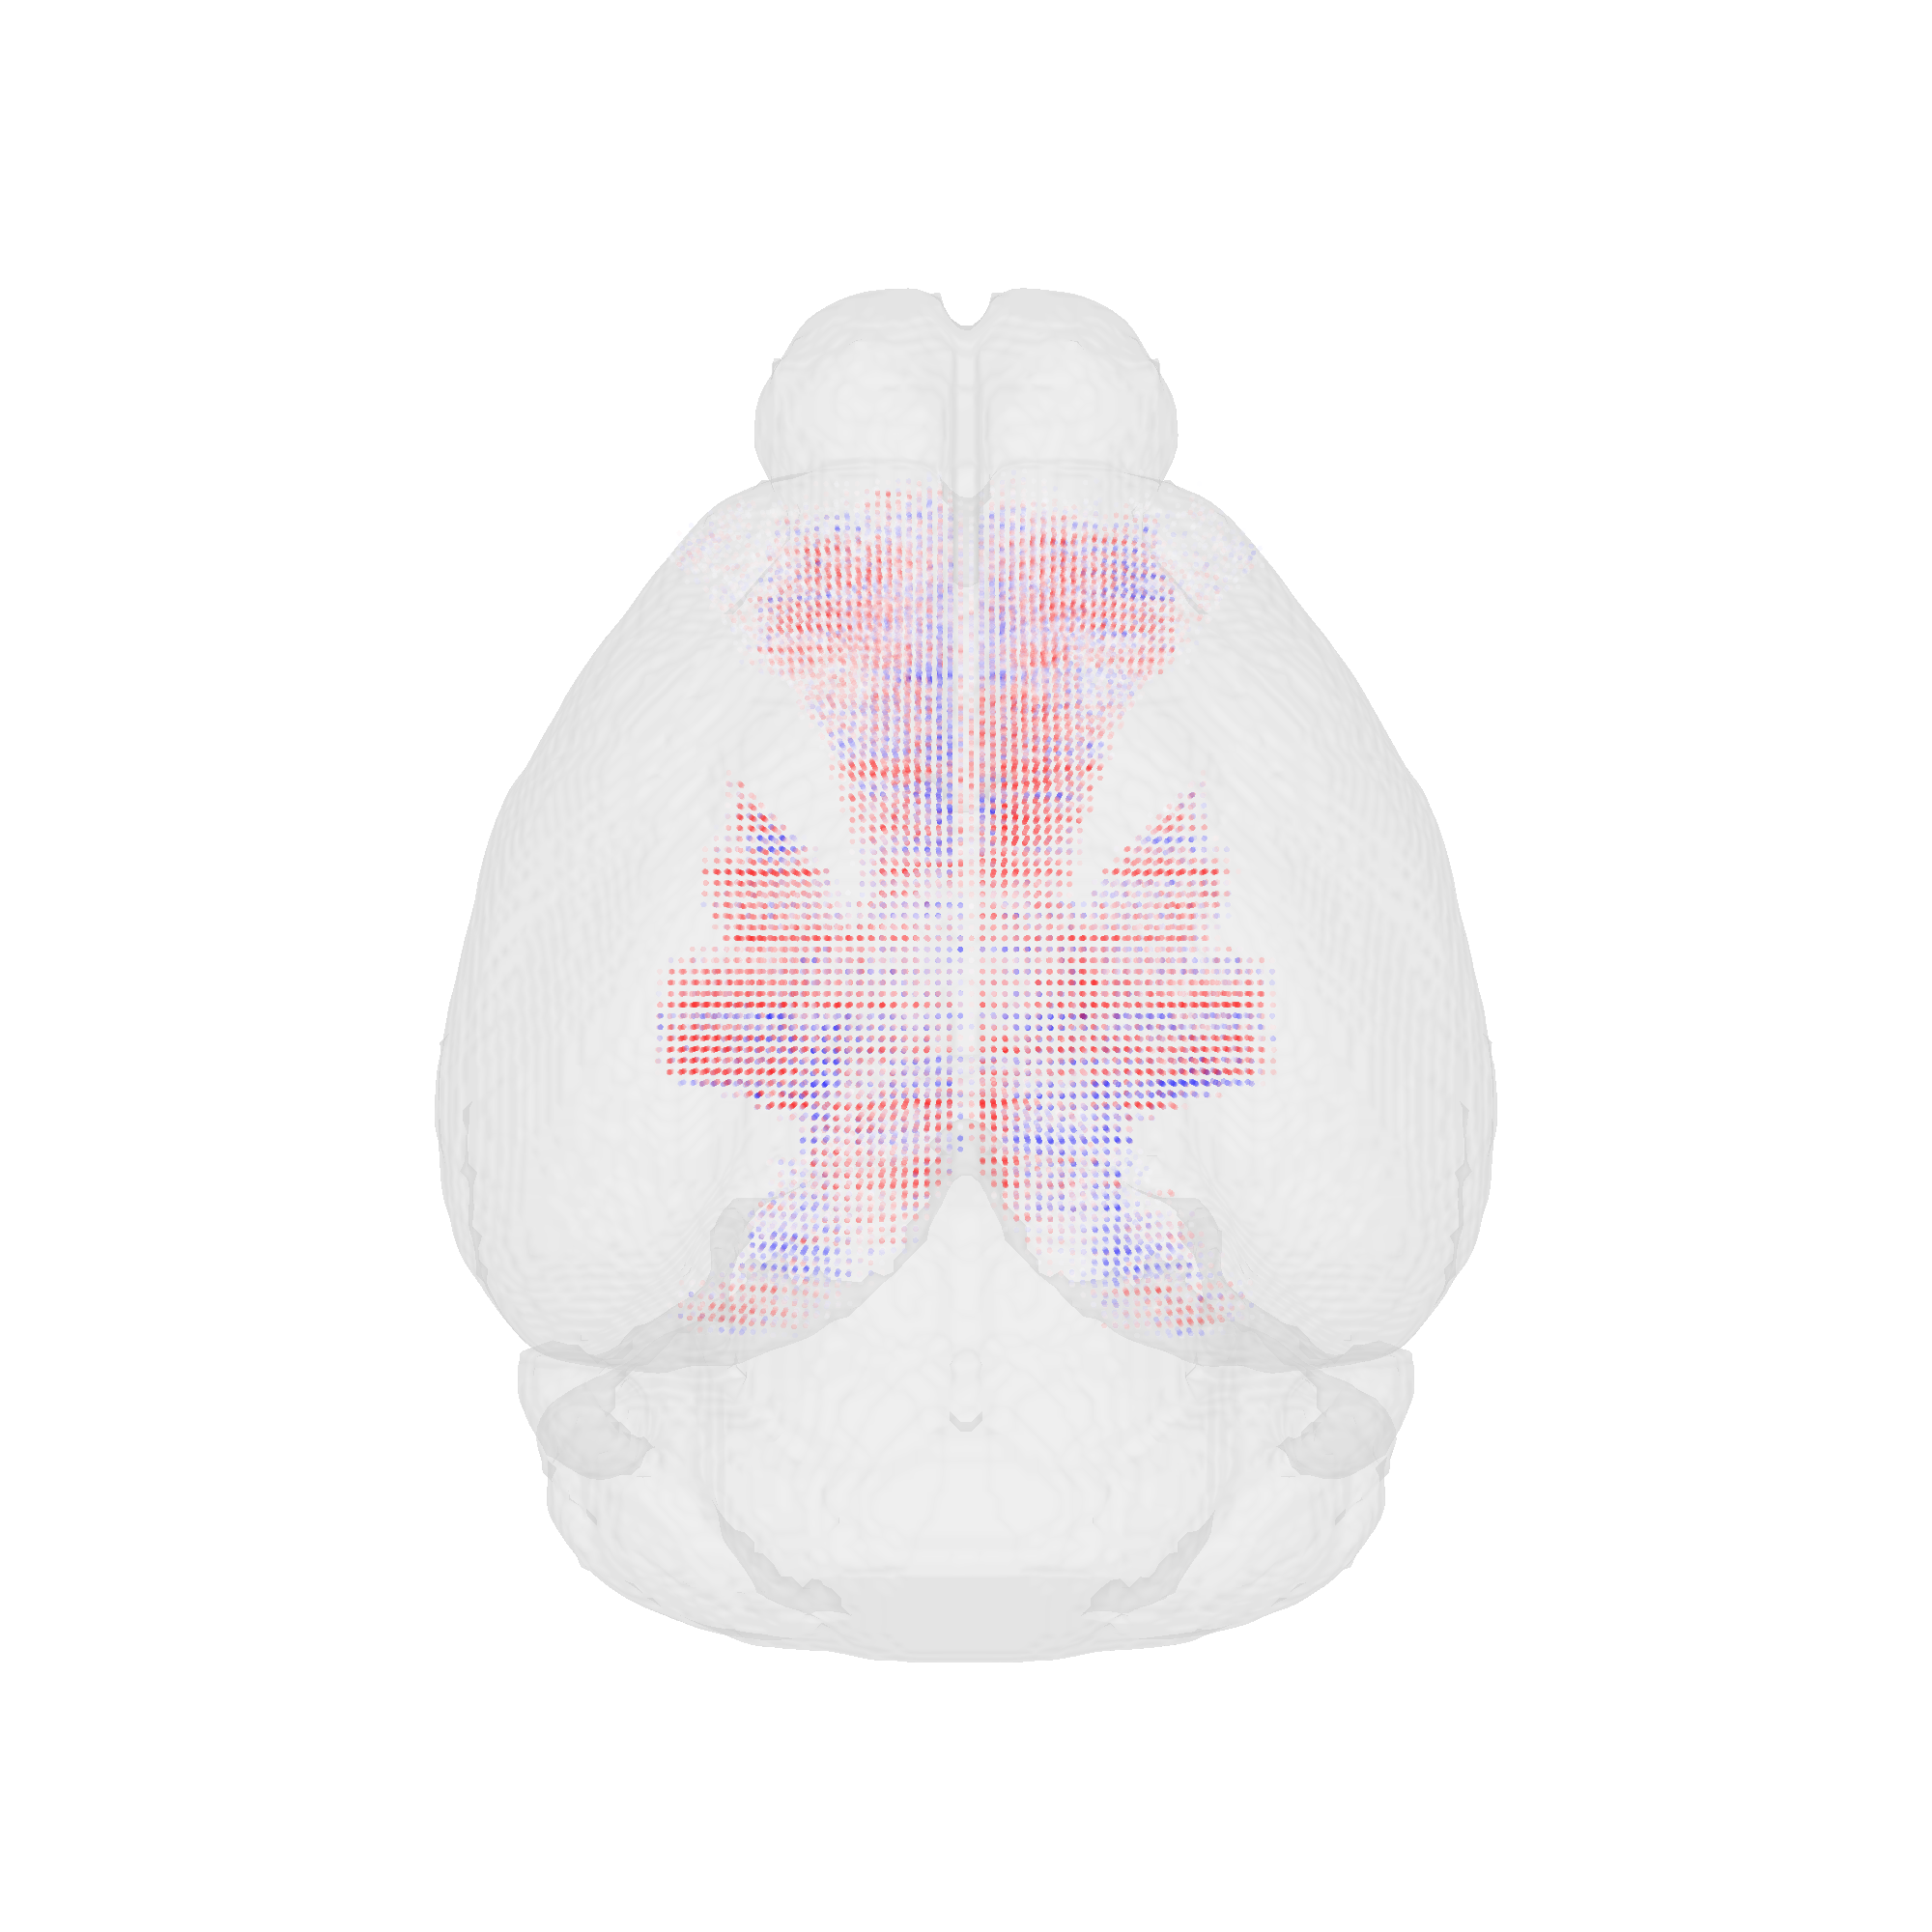

In [16]:
#3D mapping of delta C-FOS cubes
#Example Figure 7B left panel

DMN_list = ["ACAd", "ACAv", "PL", "ILA", "ORBl", "ORBm", "ORBvl", 
            "VISa", "VISam", "RSPagl", "RSPd", "RSPv", 
            "SSp-tr", "SSp-ll", "MOs"]

def cfos_spot_diff (df1_u, df2_u, hemisphere_u, structure_list):
    pd_diff_all = pd.DataFrame()
    for structure in structure_list:

        df1_structure = df1_u[(df1_u["hemisphere"]==hemisphere_u)&(df1_u["structure"]==structure)]
        df2_structure = df2_u[(df2_u["hemisphere"]==hemisphere_u)&(df2_u["structure"]==structure)]
        df1_structure["xyz"]=[(varaa["z(micrometer)"], varaa["y(micrometer)"], varaa["x(micrometer)"]) for indexa, varaa in df1_structure.iterrows()]
        df2_structure["xyz"]=[(varaa["z(micrometer)"], varaa["y(micrometer)"], varaa["x(micrometer)"]) for indexa, varaa in df2_structure.iterrows()]
        df1_structure.set_index(["xyz"], inplace = True)
        df2_structure.set_index(["xyz"], inplace = True)
        common_xyz = list(set(df1_structure.index.tolist()).intersection(set(df2_structure.index.tolist())))
        diff = df2_structure.loc[common_xyz, "Density (cells/cubic millimeter)"]-df1_structure.loc[common_xyz, "Density (cells/cubic millimeter)"]
        diff_pd = pd.DataFrame({"xyz":common_xyz, "diff":diff.tolist()})
        diff_pd["structure"]=structure
        diff_pd["hemisphere"]=hemisphere_u
        pd_diff_all = pd.concat([pd_diff_all, diff_pd], axis =0)
    return pd_diff_all

contra_WT_Tbr1_ctrl = cfos_spot_diff(WT_ctrl_cfos_loc_DMN_down, Tbr1_ctrl_cfos_loc_DMN_down, "Left", DMN_list)
ipsi_WT_Tbr1_ctrl = cfos_spot_diff(WT_ctrl_cfos_loc_DMN_down, Tbr1_ctrl_cfos_loc_DMN_down, "Right", DMN_list)
WT_Tbr1_ctrl = pd.concat([contra_WT_Tbr1_ctrl, ipsi_WT_Tbr1_ctrl])

xyz_list = WT_Tbr1_ctrl["xyz"].tolist()
diff_list = WT_Tbr1_ctrl["diff"].tolist()

vmin, vmax = np.min(diff_list), np.max(diff_list)
scale = abs(vmax-vmin)
scale_diff = diff_list/scale
min_value = min(scale_diff)
max_value = max(scale_diff)

color = [vedo.color_map(v, "bwr", -0.1, 0.1) for v in scale_diff]

s = vedo.Spheres(xyz_list, r = 25, alpha= 0.2, res = 20, c = color).lighting("off")

root = vedo.load("root_small.vtk")
root.cmap("gray_r").alpha(0.4).lighting("ambient")

#show 3D mapping
vedo.settings.default_backend = '2d' #set to 'k3d' for interactive plotting
vedo.show(root, s, azimuth=0, elevation=-90, roll=270, zoom = 1, size = (2000, 2000))

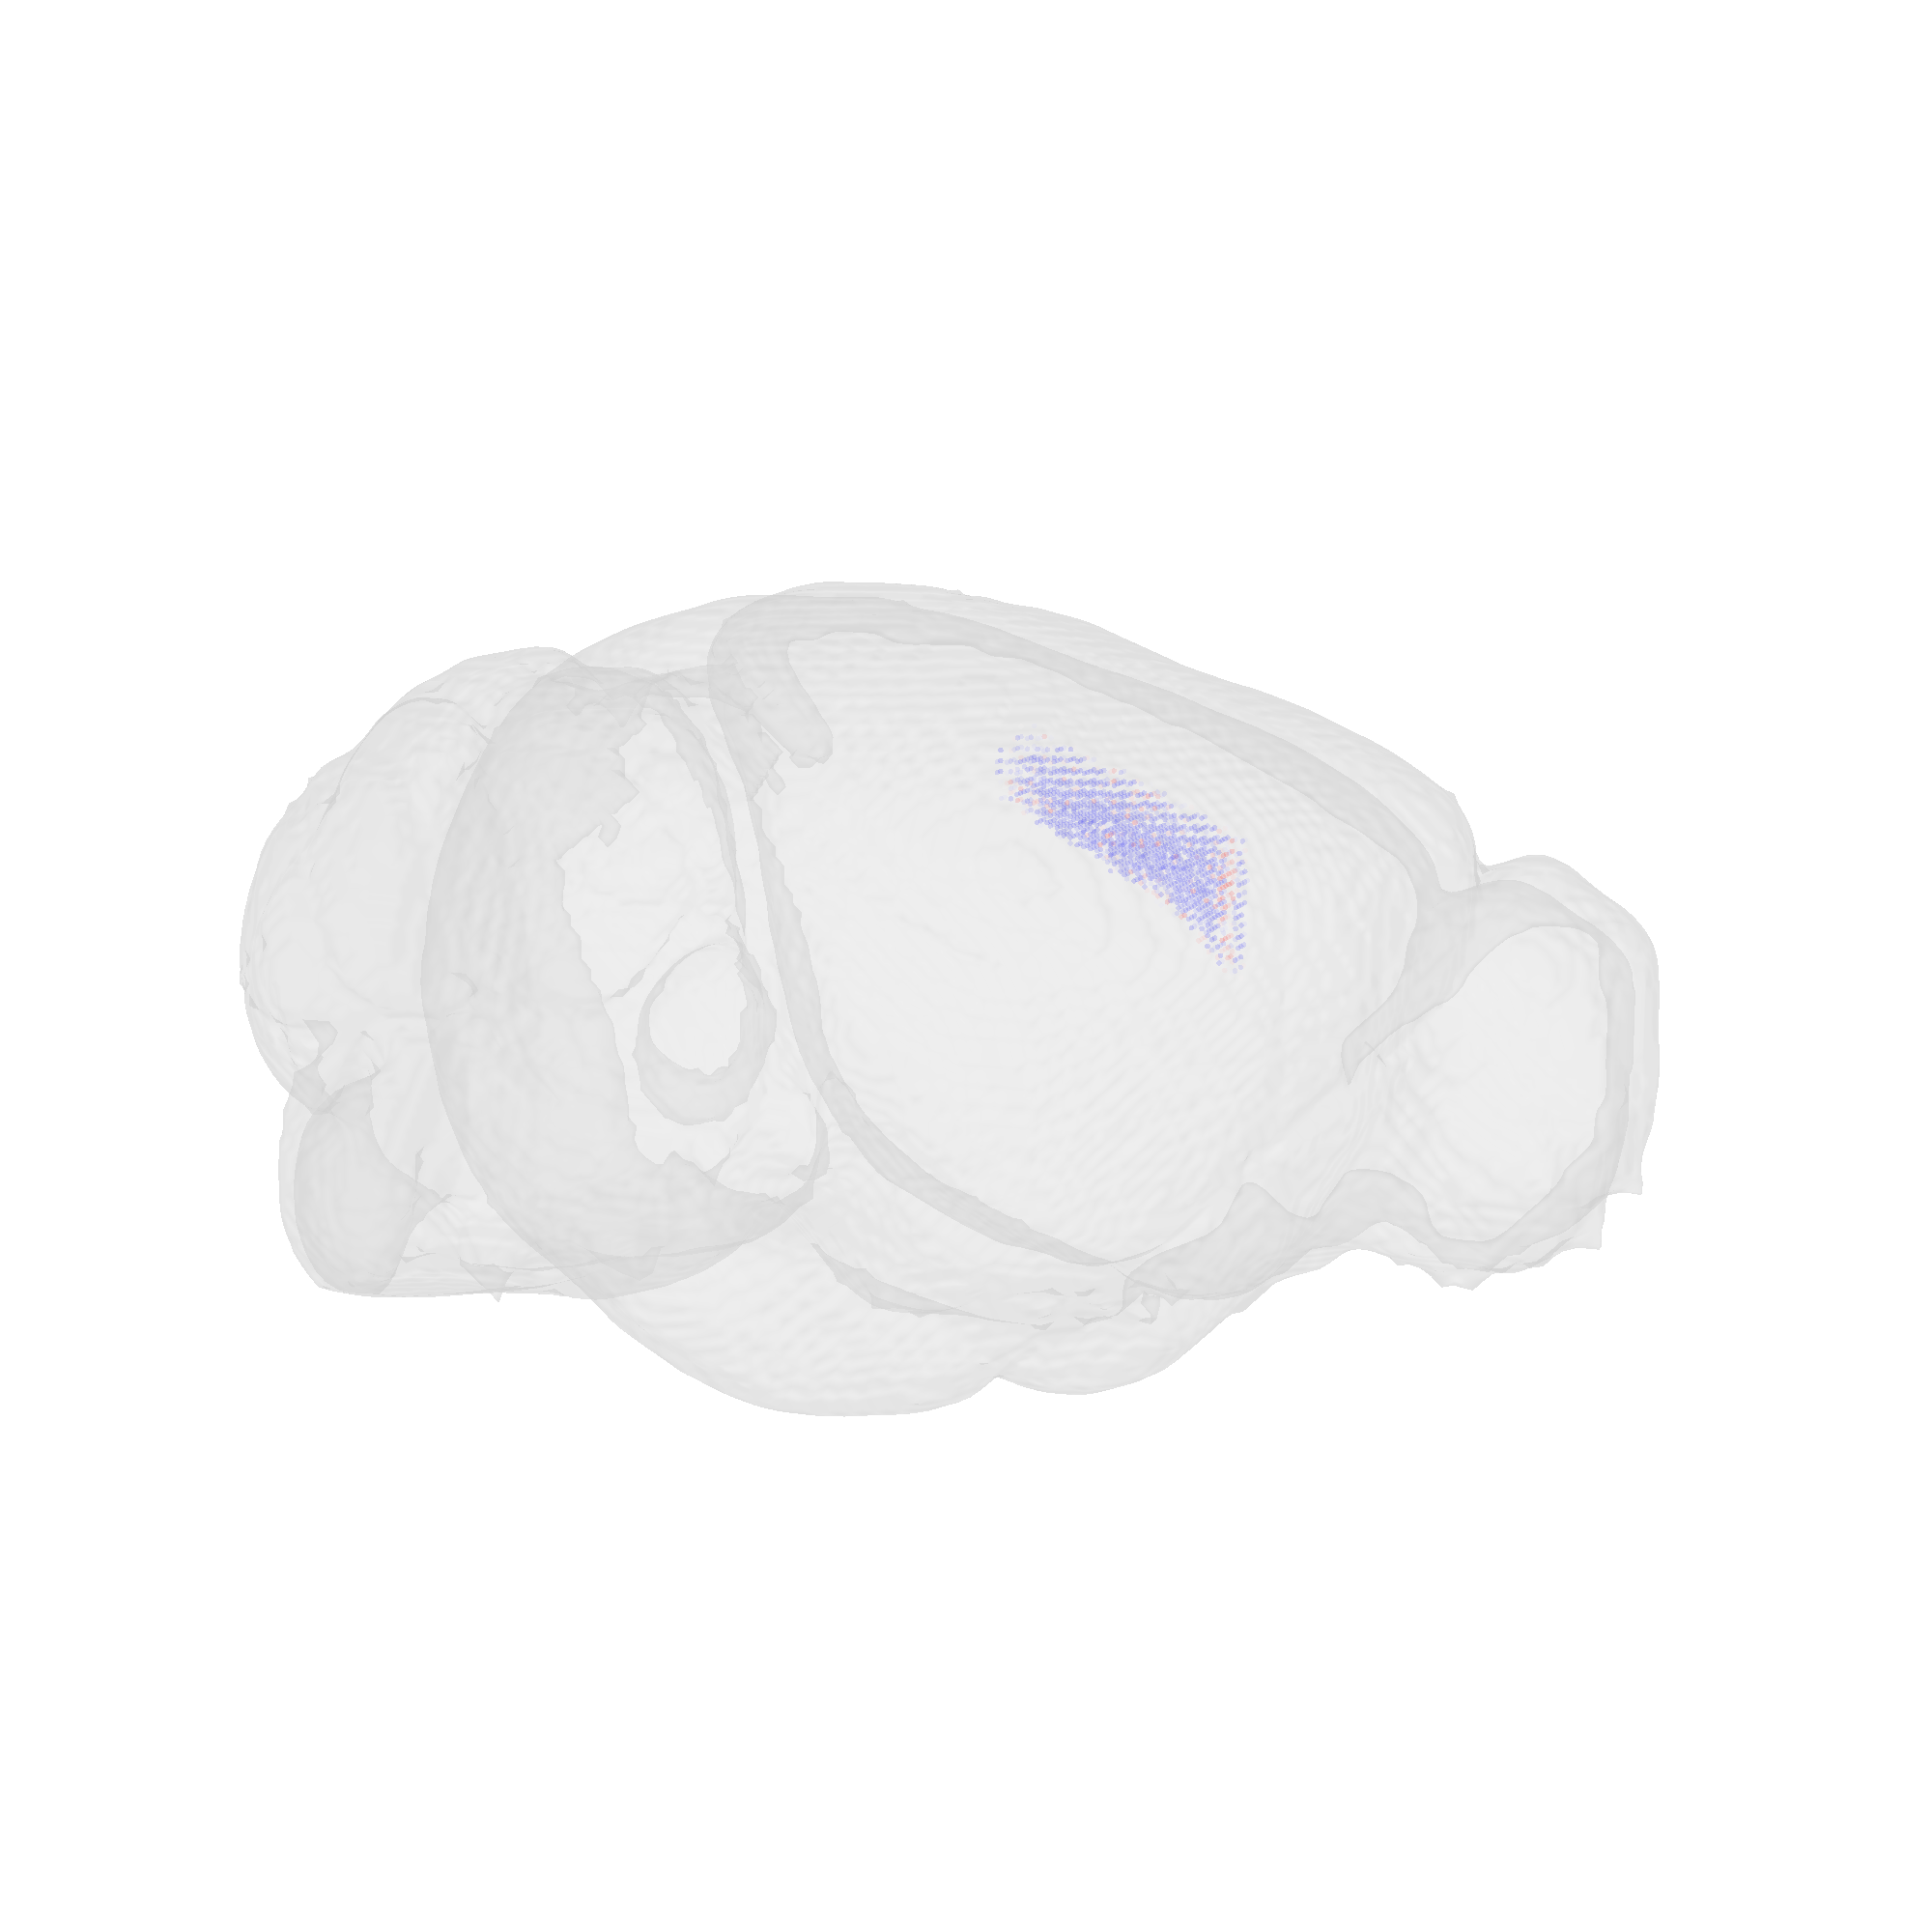

In [17]:
#create delta delta C-FOS cubes
#Example:only ACAv region in Figure 4C middle left panel

ipsi_list = ['ACAv']


def delta_delta_cfos_spot_diff (WT_nost_df, WT_TBS_df, Tbr1_nost_df, Tbr1_TBS_df, hemisphere, structure_list):


    def cfos_spot_diff (df1_u, df2_u, hemisphere_u, structure_u):

        df1_structure = df1_u[(df1_u["hemisphere"]==hemisphere_u)&(df1_u["structure"]==structure_u)]
        df2_structure = df2_u[(df2_u["hemisphere"]==hemisphere_u)&(df2_u["structure"]==structure_u)]
        df1_structure["xyz"]=[(varaa["z(micrometer)"], varaa["y(micrometer)"], varaa["x(micrometer)"]) for indexa, varaa in df1_structure.iterrows()]
        df2_structure["xyz"]=[(varaa["z(micrometer)"], varaa["y(micrometer)"], varaa["x(micrometer)"]) for indexa, varaa in df2_structure.iterrows()]
        df1_structure.set_index(["xyz"], inplace = True)
        df2_structure.set_index(["xyz"], inplace = True)
        common_xyz = list(set(df1_structure.index.tolist()).intersection(set(df2_structure.index.tolist())))
        diff = df2_structure.loc[common_xyz, "Density (cells/cubic millimeter)"]-df1_structure.loc[common_xyz, "Density (cells/cubic millimeter)"]
        diff_pd = pd.DataFrame({"xyz":common_xyz, "diff":diff.tolist()})
        return diff_pd
    
    pd_diff_all = pd.DataFrame()
    for structure in structure_list:
        diff_WT = cfos_spot_diff(WT_nost_df, WT_TBS_df, hemisphere, structure)
        diff_Tbr1 = cfos_spot_diff(Tbr1_nost_df, Tbr1_TBS_df, hemisphere, structure)
        diff_WT.set_index(["xyz"], inplace = True)
        diff_Tbr1.set_index(["xyz"], inplace = True)
        com_xyz = list(set(diff_WT.index.tolist()).intersection(set(diff_Tbr1.index.tolist())))
        diff_Tbr1_WT = diff_Tbr1.loc[com_xyz, "diff"]-diff_WT.loc[com_xyz, "diff"]
        pd_structure = pd.DataFrame({"xyz": com_xyz, "diff": diff_Tbr1_WT.tolist()})
        pd_structure["structure"]=structure
        pd_diff_all = pd.concat([pd_diff_all, pd_structure], axis =0)
    return pd_diff_all

ipsi_cfos_diff = delta_delta_cfos_spot_diff (WT_ctrl_cfos_loc_DMN_down,
                                             WT_TBS_cfos_loc_DMN_down,
                                             Tbr1_ctrl_cfos_loc_DMN_down,
                                             Tbr1_TBS_cfos_loc_DMN_down,
                                             "Right",
                                             ipsi_list)

xyz_list = ipsi_cfos_diff["xyz"].tolist()
diff_list = ipsi_cfos_diff["diff"].tolist()

vmin, vmax = np.min(diff_list), np.max(diff_list)
scale = abs(vmax-vmin)
scale_diff = diff_list/scale
min_value = min(scale_diff)
max_value = max(scale_diff)

color = [vedo.color_map(v, "bwr", -0.1, 0.1) for v in scale_diff]

s = vedo.Spheres(xyz_list, r = 25, alpha= 0.1, res = 20, c = color).lighting("off")

root = vedo.load("root_small.vtk")
root.cmap("gray_r").alpha(0.4).lighting("ambient")

#show 3D mapping
vedo.settings.default_backend ='2d'
vedo.show(root, s, azimuth=-20, elevation=-10, roll=180, zoom = 1, size = (2000, 2000))


In [18]:
#formation of area correlation table

#loading C-FOS correlation martix
WT_ctrl_com = pd.read_csv ("correlation/WT_ctrl.csv", index_col = 0)
Tbr1_ctrl_com = pd.read_csv ("correlation/Tbr1_ctrl.csv", index_col = 0)
WT_TBS_com = pd.read_csv ("correlation/WT_TBS.csv", index_col = 0)
Tbr1_TBS_com = pd.read_csv ("correlation/Tbr1_TBS.csv", index_col = 0)

#add areas
parent_structure = pd.read_csv ("CCFv3/structuretree/structure_list_paper_cfos.csv", index_col = 0)

structure_list = list(WT_ctrl_com["structure"])
label_list = list(parent_structure["LABEL"])
label_dict = {si : i for i,si in enumerate(label_list)}
index_list = list(itemgetter(*structure_list)(label_dict))
WT_ctrl_com["area"] = parent_structure.iloc[index_list]["area"].tolist()
Tbr1_ctrl_com["area"] = parent_structure.iloc[index_list]["area"].tolist()
WT_TBS_com["area"] = parent_structure.iloc[index_list]["area"].tolist()
Tbr1_TBS_com["area"] = parent_structure.iloc[index_list]["area"].tolist()


WT_ctrl_com["area"] = [str("i_")+ a for a in WT_ctrl_com[WT_ctrl_com["hemisphere"]=="ipsi"]["area"].tolist()]+[str("c_")+ a for a in WT_ctrl_com[WT_ctrl_com["hemisphere"]=="contra"]["area"].tolist()]
Tbr1_ctrl_com["area"] = [str("i_")+ a for a in Tbr1_ctrl_com[Tbr1_ctrl_com["hemisphere"]=="ipsi"]["area"].tolist()]+[str("c_")+ a for a in Tbr1_ctrl_com[Tbr1_ctrl_com["hemisphere"]=="contra"]["area"].tolist()]
WT_TBS_com["area"] = [str("i_")+ a for a in WT_TBS_com[WT_TBS_com["hemisphere"]=="ipsi"]["area"].tolist()]+[str("c_")+ a for a in WT_TBS_com[WT_TBS_com["hemisphere"]=="contra"]["area"].tolist()]
Tbr1_TBS_com["area"] = [str("i_")+ a for a in Tbr1_TBS_com[Tbr1_TBS_com["hemisphere"]=="ipsi"]["area"].tolist()]+[str("c_")+ a for a in Tbr1_TBS_com[Tbr1_TBS_com["hemisphere"]=="contra"]["area"].tolist()]

area_list_ic = ["i_Prefrontal", "i_Somatomotor", "i_Medial", "i_Lateral", "i_Auditory", "i_Visual", "i_Olfactory areas", "i_Hippocampal formation", "i_Cortical subplate", 
                 "i_Cerebral nuclei", "i_Thalamus", "i_Hypothalamus", "i_Midbrain", "i_Hindbrain",
                 "c_Prefrontal", "c_Somatomotor", "c_Medial", "c_Lateral", "c_Auditory", "c_Visual", "c_Olfactory areas", "c_Hippocampal formation", "c_Cortical subplate", 
                 "c_Cerebral nuclei", "c_Thalamus", "c_Hypothalamus", "c_Midbrain", "c_Hindbrain"]

def area_mean_corr(df):
    df_c = df.copy()
    community_list = area_list_ic
    for indexa, varaa in df.iterrows():
        df.loc[indexa, indexa]=np.nan
    df_area = pd.DataFrame(index = community_list, columns = community_list)
    for a in community_list:
        com_index = df.loc[df["area"]==a].index.tolist()
        for b in community_list:
            com_column = df.loc[df["area"]==b].index.tolist()
            df_sp = df.loc[com_index,com_column]
            #if not (len(pd.melt(df_sp))==1)&(com_index==com_column):
            mean_corr = np.mean (df_sp.mean())
            df_c.loc[com_index,com_column]=mean_corr
            df_area.loc[a,b] = mean_corr.astype("float")
    rearange_index = df_c.sort_values(by=["area"]).index.tolist()
    return df_c.loc[rearange_index,rearange_index], df_area

WT_ctrl_com_mean, WT_ctrl_com_area = area_mean_corr(WT_ctrl_com)
Tbr1_ctrl_com_mean, Tbr1_ctrl_com_area= area_mean_corr(Tbr1_ctrl_com)
WT_TBS_com_mean, WT_TBS_com_area= area_mean_corr(WT_TBS_com)
Tbr1_TBS_com_mean, Tbr1_TBS_com_area= area_mean_corr(Tbr1_TBS_com)
WT_ctrl_com_area["mean_correlation"] = [WT_ctrl_com_area.loc[a,a] for a in area_list_ic]
Tbr1_ctrl_com_area["mean_correlation"] = [Tbr1_ctrl_com_area.loc[a,a] for a in area_list_ic]
WT_TBS_com_area["mean_correlation"] = [WT_TBS_com_area.loc[a,a] for a in area_list_ic]
Tbr1_TBS_com_area["mean_correlation"] = [Tbr1_TBS_com_area.loc[a,a] for a in area_list_ic]
WT_ctrl_com_area.replace(0, np.nan, inplace=True)
Tbr1_ctrl_com_area.replace(0, np.nan, inplace=True)
WT_TBS_com_area.replace(0, np.nan, inplace=True)
Tbr1_TBS_com_area.replace(0, np.nan, inplace=True)

def df_to_network_area (df):
    df_network = nx.from_pandas_adjacency(df.iloc[:,:-1])
    df_network.remove_edges_from(nx.selfloop_edges(df_network))
    for n, d in df_network.nodes(data = True):
        d["mean_correlation"] = df["mean_correlation"][n]
    return df_network
WT_ctrl_area_network = df_to_network_area(WT_ctrl_com_area)
Tbr1_ctrl_area_network = df_to_network_area(Tbr1_ctrl_com_area)
WT_TBS_area_network = df_to_network_area(WT_TBS_com_area)
Tbr1_TBS_area_network = df_to_network_area(Tbr1_TBS_com_area)

WT_ctrl_cfos_center= pd.read_csv("./correlation/WT_ctrl_cfos_center.csv", index_col=0)
Tbr1_ctrl_cfos_center= pd.read_csv("./correlation/Tbr1_ctrl_cfos_center.csv", index_col=0)
WT_TBS_cfos_center= pd.read_csv("./correlation/WT_TBS_cfos_center.csv", index_col=0)
Tbr1_TBS_cfos_center= pd.read_csv("./correlation/Tbr1_TBS_cfos_center.csv", index_col=0)

WT_ctrl_cfos_center["mean_correlation"]=WT_ctrl_com_area["mean_correlation"].tolist()
Tbr1_ctrl_cfos_center["mean_correlation"]=Tbr1_ctrl_com_area["mean_correlation"].tolist()
WT_TBS_cfos_center["mean_correlation"]=WT_TBS_com_area["mean_correlation"].tolist()
Tbr1_TBS_cfos_center["mean_correlation"]=Tbr1_TBS_com_area["mean_correlation"].tolist()

def add_location_to_correlation_table (df_center, df_network):
    correlation_table = utils.edge_table(df_network)

    source_location = []
    target_location = []

    for a in correlation_table["source"].tolist():
        if a[:1]=="i":
            location_df = df_center[(df_center["hemisphere"]=="Right")&(df_center["structure"]==a[2:])]
            if (len(location_df)>0):
                location = [location_df["z_center"].tolist()[0], location_df["y_center"].tolist()[0], location_df["x_center"].tolist()[0]]
        elif a[:1]=="c":
            location_df = df_center[(df_center["hemisphere"]=="Left")&(df_center["structure"]==a[2:])]
            if (len(location_df)>0):
                location = [location_df["z_center"].tolist()[0], location_df["y_center"].tolist()[0], location_df["x_center"].tolist()[0]]
        else:
            location = np.nan
        source_location.append(location)

    for b in correlation_table["target"].tolist():
        if b[:1]=="i":
            location_t_df = df_center[(df_center["hemisphere"]=="Right")&(df_center["structure"]==b[2:])]
            if (len(location_t_df)>0):
                location_t = [location_df["z_center"].tolist()[0], location_df["y_center"].tolist()[0], location_df["x_center"].tolist()[0]]
        elif b[:1]=="c":
            location_t_df = df_center[(df_center["hemisphere"]=="Left")&(df_center["structure"]==b[2:])]
            if (len(location_t_df)>0):
                location_t = [location_df["z_center"].tolist()[0], location_df["y_center"].tolist()[0], location_df["x_center"].tolist()[0]]
        else:
            location_t = np.nan
        
        target_location.append(location_t)
        
    correlation_table["source_location"]= source_location
    correlation_table["target_location"]= target_location

    return correlation_table

WT_ctrl_correlation_table = add_location_to_correlation_table(WT_ctrl_cfos_center, WT_ctrl_area_network)
Tbr1_ctrl_correlation_table = add_location_to_correlation_table(Tbr1_ctrl_cfos_center, Tbr1_ctrl_area_network)
WT_TBS_correlation_table = add_location_to_correlation_table(WT_TBS_cfos_center, WT_TBS_area_network)
Tbr1_TBS_correlation_table = add_location_to_correlation_table(Tbr1_TBS_cfos_center, Tbr1_TBS_area_network)

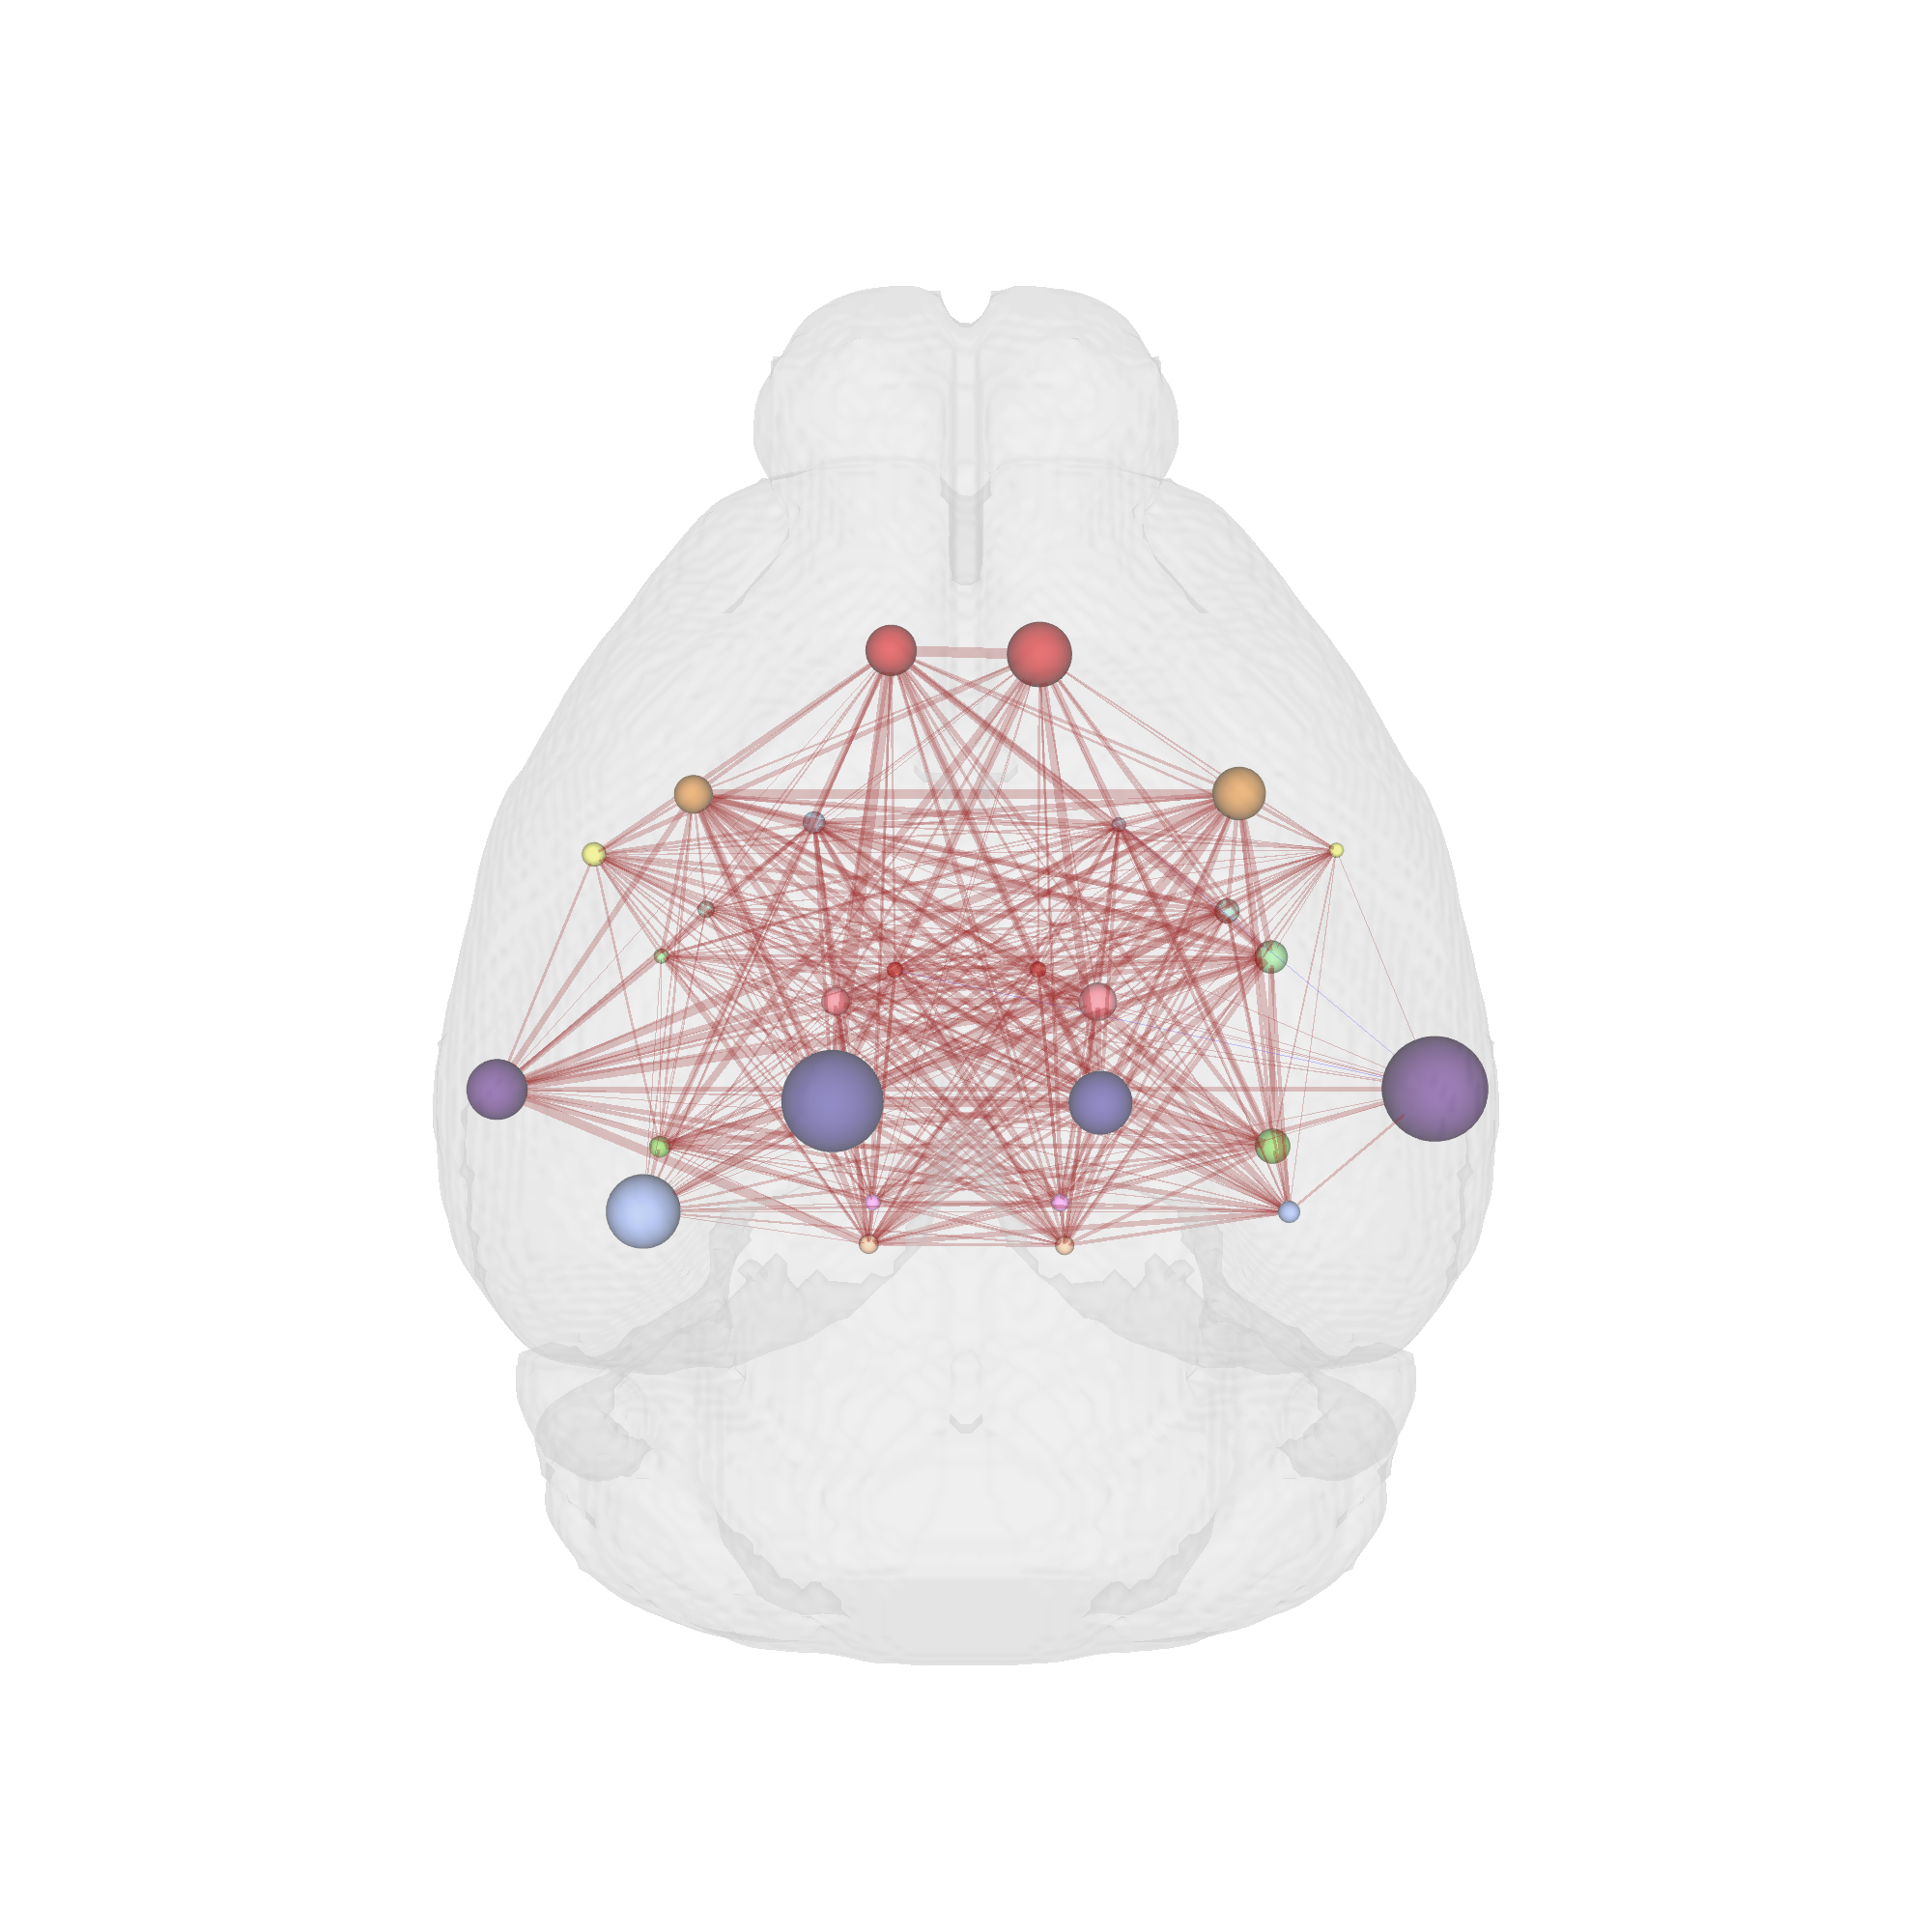

In [19]:
#3D mapping of C-FOS mean correlation network amon major brain areas
#Example: Figure 5C WT ctrl horizontal view

area_list = ["Prefrontal", "Somatomotor", "Medial", "Lateral", "Auditory", "Visual", "Olfactory areas", "Hippocampal formation", "Cortical subplate", 
                 "Cerebral nuclei", "Thalamus", "Hypothalamus", "Midbrain", "Hindbrain"]

def vedo_cfos_network (df, structure_list_contra, structure_list_ipsi):
    root = vedo.load("root_small.vtk")
    root.cmap("gray_r").alpha(0.4).lighting("ambient")

    model = [root]

    for a in structure_list_contra:
        contra_structure = df[(df["hemisphere"]=="Left")&(df["structure"]==a)]
        if len(contra_structure)>0:
            pts_contra = [(contra_structure["z_center"][indexa], contra_structure["y_center"][indexa], contra_structure["x_center"][indexa]) for indexa, varaa in contra_structure.iterrows()]
            color_contra = vedo.colors.build_palette(np.unique(contra_structure["color"].values)[0], np.unique(contra_structure["color"].values)[0], 2)
            
            contra_s = vedo.Spheres(pts_contra, r = contra_structure["mean_correlation"]*700, alpha= 1, res = 20).cmap(color_contra).lighting("default")

            model.append(contra_s)

    for b in structure_list_ipsi:
        ipsi_structure = df[(df["hemisphere"]=="Right")&(df["structure"]==b)]
        if len(ipsi_structure)>0:
            pts_ipsi = [(ipsi_structure["z_center"][indexb], ipsi_structure["y_center"][indexb], ipsi_structure["x_center"][indexb]) for indexb, varab in ipsi_structure.iterrows()]
            color_ipsi = vedo.colors.build_palette(np.unique(ipsi_structure["color"].values)[0], np.unique(ipsi_structure["color"].values)[0], 2)
            ipsi_s = vedo.Spheres(pts_ipsi, r = ipsi_structure["mean_correlation"]*700, alpha= 1, res = 20).cmap(color_ipsi).lighting("default")

            model.append(ipsi_s)

    return model

cfos_model = vedo_cfos_network (WT_ctrl_cfos_center, area_list , area_list)

def vedo_line_model (correlation_table):

    loc_num = [int(s) for s in np.arange(len(correlation_table)/2)*2]
    line_model =[]
    for a in loc_num:
        source_list =[varaa["source_location"] for indexa, varaa in correlation_table.iloc[a:a+2, :].iterrows()]
        target_list =[varaa["target_location"] for indexa, varaa in correlation_table.iloc[a:a+2, :].iterrows()]
        if np.mean(correlation_table.iloc[a:a+2, :]["weight"])>0:
            line = vedo.Line(p0=source_list, p1 = target_list, lw=abs(np.mean(correlation_table.iloc[a:a+2, :]["weight"]))*30, res = 5, c = "#800000", alpha = 0.3)
        elif np.mean(correlation_table.iloc[a:a+2, :]["weight"])<0:
            line = vedo.Line(p0=source_list, p1 = target_list, lw=abs(np.mean(correlation_table.iloc[a:a+2, :]["weight"]))*30, res = 5, c = "blue", alpha = 0.3)
        line_model.append(line)
    return line_model

cfos_line_model = vedo_line_model(WT_ctrl_correlation_table)

#show 3D mapping
vedo.settings.default_backend ='2d'
vedo.show(cfos_model, cfos_line_model, azimuth=0, elevation=-90, roll=270, resetcam = True, zoom = 1, size=(2000, 2000))